In [1]:
import numpy as np
import pandas as pd
import scipy.io as sio
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.signal import butter, filtfilt, resample, welch
from scipy.fft import fft, fftfreq, ifft
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from scipy.interpolate import interp1d
import datetime
import time
import sys
import os


In [2]:
#Dữ liệu gốc lưu ở
data_path = '/content/data/bidmc_data.mat'

# Đường dẫn đến file dữ liệu
figures_path = '/content/figures'
processed_data_path = '/content/data/processed'
results_path = '/content/results'
model_path = '/content/models'

In [3]:
# Tạo thư mục nếu chưa tồn tại
os.makedirs(model_path, exist_ok=True)
os.makedirs(figures_path, exist_ok=True)
os.makedirs(results_path, exist_ok=True)
os.makedirs(processed_data_path, exist_ok=True)

#Explore

Các file khởi tạo

In [4]:
print("Đang tải dữ liệu từ file .mat...")
mat_data = sio.loadmat(data_path)
data = mat_data['data'][0]  # Lấy mảng chính chứa 53 bản ghi

# Khám phá cấu trúc dữ liệu
print(f"Số lượng bản ghi: {len(data)}")
first_record = data[0]
print("\nKhám phá cấu trúc chi tiết của bản ghi đầu tiên:")

# Kiểm tra cấu trúc PPG
ppg_field = first_record['ppg'][0, 0]
print(f"Cấu trúc trường ppg: {type(ppg_field)}")
if hasattr(ppg_field, 'dtype') and hasattr(ppg_field.dtype, 'names'):
    print(f"-- con: {ppg_field.dtype.names}")

# Kiểm tra cấu trúc của trường ref
ref_field = first_record['ref'][0, 0]
print(f"Cấu trúc trường ref: {type(ref_field)}")
if hasattr(ref_field, 'dtype') and hasattr(ref_field.dtype, 'names'):
    print(f"-- con: {ref_field.dtype.names}: {type(ref_field.dtype.names)}/n")

    # Kiểm tra cấu trúc của trường params trong ref
    if 'params' in ref_field.dtype.names:
        params_field = ref_field['params'][0, 0]
        print(f"Cấu trúc trường params: {type(params_field)}")
        if hasattr(params_field, 'dtype') and hasattr(params_field.dtype, 'names'):
            print(f"-- con: {params_field.dtype.names}")

# Kiểm tra chi tiết hơn về cấu trúc dữ liệu
print("\nKiểm tra chi tiết hơn về cấu trúc dữ liệu:")
print(f"Kiểu dữ liệu của ppg.v: {type(first_record['ppg'][0, 0]['v'])}")
print(f"Kích thước của ppg.v: {first_record['ppg'][0, 0]['v'].shape}")
print(f"Kiểu dữ liệu của ref.params.hr: {type(first_record['ref'][0, 0]['params'][0, 0]['hr'])}")
print(f"Kích thước của ref.params.hr: {first_record['ref'][0, 0]['params'][0, 0]['hr'].shape}")

# Trích xuất và vẽ tín hiệu PPG từ bản ghi đầu tiên
try:
    # Truy cập trực tiếp vào dữ liệu PPG
    ppg_data = first_record['ppg'][0, 0]['v']
    if isinstance(ppg_data, np.ndarray):
        # Nếu là mảng numpy, lấy dữ liệu trực tiếp
        sample_ppg = ppg_data.flatten()
    else:
        # Nếu không phải mảng numpy, chuyển đổi thành mảng
        sample_ppg = np.array(ppg_data, dtype=float).flatten()

    # Lấy tần số lấy mẫu
    sample_fs_ppg = float(first_record['ppg'][0, 0]['fs'][0, 0])

    # Tương tự cho ECG và Resp
    ecg_data = first_record['ekg'][0, 0]['v']
    if isinstance(ecg_data, np.ndarray):
        sample_ecg = ecg_data.flatten()
    else:
        sample_ecg = np.array(ecg_data, dtype=float).flatten()

    sample_fs_ecg = float(first_record['ekg'][0, 0]['fs'][0, 0])

    resp_data = first_record['ref'][0, 0]['resp_sig'][0, 0]['imp'][0, 0]['v']
    if isinstance(resp_data, np.ndarray):
        sample_resp = resp_data.flatten()
    else:
        sample_resp = np.array(resp_data, dtype=float).flatten()

    sample_fs_resp = float(first_record['ref'][0, 0]['resp_sig'][0, 0]['imp'][0, 0]['fs'][0, 0])

    print(f"\nTần số lấy mẫu PPG: {sample_fs_ppg} Hz")
    print(f"Tần số lấy mẫu ECG: {sample_fs_ecg} Hz")
    print(f"Tần số lấy mẫu Resp: {sample_fs_resp} Hz")

    print(f"Độ dài tín hiệu PPG: {len(sample_ppg)} mẫu")
    print(f"Độ dài tín hiệu ECG: {len(sample_ecg)} mẫu")
    print(f"Độ dài tín hiệu Resp: {len(sample_resp)} mẫu")

    # Tính thời gian cho trục x
    time_ppg = np.arange(len(sample_ppg)) / sample_fs_ppg
    time_ecg = np.arange(len(sample_ecg)) / sample_fs_ecg
    time_resp = np.arange(len(sample_resp)) / sample_fs_resp

    # Vẽ tín hiệu mẫu
    plt.figure(figsize=(15, 10))

    plt.subplot(3, 1, 1)
    plt.plot(time_ecg[:1000], sample_ecg[:1000])
    plt.title('ECG Signal (First Record - First 1000 samples)')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    plt.subplot(3, 1, 2)
    plt.plot(time_ppg[:1000], sample_ppg[:1000])
    plt.title('PPG Signal (First Record - First 1000 samples)')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    plt.subplot(3, 1, 3)
    plt.plot(time_resp[:1000], sample_resp[:1000])
    plt.title('Respiratory Signal (First Record - First 1000 samples)')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    plt.tight_layout()
    plt.savefig(os.path.join(figures_path, 'sample_signals.png'))
    plt.close()

    # Phân tích phổ tần số của tín hiệu PPG
    def plot_fft(signal, fs, title, filename):
        N = len(signal)
        T = 1.0 / fs
        yf = fft(signal)
        xf = fftfreq(N, T)[:N//2]

        plt.figure(figsize=(10, 6))
        plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
        plt.grid(True, alpha=0.3)
        plt.title(f'FFT of {title}')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Amplitude')
        plt.xlim(0, 5)  # Giới hạn tần số hiển thị đến 5Hz
        plt.savefig(os.path.join(figures_path, filename))
        plt.close()

    # Phân tích phổ tần số của tín hiệu PPG, ECG và Resp
    plot_fft(sample_ppg, sample_fs_ppg, 'PPG Signal', 'ppg_fft.png')
    plot_fft(sample_ecg, sample_fs_ecg, 'ECG Signal', 'ecg_fft.png')
    plot_fft(sample_resp, sample_fs_resp, 'Respiratory Signal', 'resp_fft.png')

except Exception as e:
    print(f"Lỗi khi vẽ tín hiệu mẫu: {e}")

# Thu thập HR và RR từ tất cả các bản ghi
all_hr_values = []
all_rr_values = []
all_pr_values = []
all_spo2_values = []

for i in range(len(data)):
    try:
        record = data[i]
        params = record['ref'][0, 0]['params'][0, 0]

        # Lấy HR, RR, PR và SpO2 từ mỗi bản ghi
        hr_data = params['hr'][0]
        rr_data = params['rr'][0]
        pr_data = params['pr'][0]
        spo2_data = params['spo2'][0]

        # Chuyển đổi sang mảng numpy nếu cần
        if not isinstance(hr_data, np.ndarray):
            hr_data = np.array(hr_data, dtype=object)
        if not isinstance(rr_data, np.ndarray):
            rr_data = np.array(rr_data, dtype=object)
        if not isinstance(pr_data, np.ndarray):
            pr_data = np.array(pr_data, dtype=object)
        if not isinstance(spo2_data, np.ndarray):
            spo2_data = np.array(spo2_data, dtype=object)

        # Trích xuất giá trị từ mảng có cấu trúc nếu cần
        if hr_data.dtype.names is not None and 'v' in hr_data.dtype.names:
            hr_values = hr_data['v']
        else:
            hr_values = hr_data

        if rr_data.dtype.names is not None and 'v' in rr_data.dtype.names:
            rr_values = rr_data['v']
        else:
            rr_values = rr_data

        if pr_data.dtype.names is not None and 'v' in pr_data.dtype.names:
            pr_values = pr_data['v']
        else:
            pr_values = pr_data

        if spo2_data.dtype.names is not None and 'v' in spo2_data.dtype.names:
            spo2_values = spo2_data['v']
        else:
            spo2_values = spo2_data

        # Kiểm tra xem dữ liệu có rỗng không trước khi chuyển đổi
        if len(hr_values) > 0:
            # Kiểm tra nếu hr_values là mảng đa chiều
            if isinstance(hr_values[0], (list, np.ndarray)):
                hr_values_flat = np.array([x[0] if isinstance(x, (list, np.ndarray)) and len(x) > 0 else x for x in hr_values])
            else:
                hr_values_flat = hr_values

            # Chuyển đổi sang float
            hr_values_flat = np.array(hr_values_flat, dtype=float)

            # Lọc các giá trị hợp lệ
            valid_hr = hr_values_flat[~np.isnan(hr_values_flat)]
            if len(valid_hr) > 0:
                all_hr_values.append(valid_hr)
        else:
            print(f"Bản ghi {i} không có dữ liệu HR")

        try:
            # Xử lý RR tương tự như HR
            if len(rr_values) > 0:
                # Kiểm tra nếu là mảng đa chiều
                if isinstance(rr_values[0], (list, np.ndarray)):
                    rr_values_flat = np.array([x[0] if isinstance(x, (list, np.ndarray)) and len(x) > 0 else x for x in rr_values])
                else:
                    rr_values_flat = rr_values

                # Chuyển đổi sang float
                rr_values_flat = np.array(rr_values_flat, dtype=float)

                # Lọc các giá trị hợp lệ
                valid_rr = rr_values_flat[~np.isnan(rr_values_flat)]
                if len(valid_rr) > 0:
                    all_rr_values.append(valid_rr)
        except Exception as e:
            pass  # Bỏ qua thông báo lỗi để giảm output

        # Áp dụng tương tự cho PR
        try:
            if len(pr_values) > 0:
                if isinstance(pr_values[0], (list, np.ndarray)):
                    pr_values_flat = np.array([x[0] if isinstance(x, (list, np.ndarray)) and len(x) > 0 else x for x in pr_values])
                else:
                    pr_values_flat = pr_values

                pr_values_flat = np.array(pr_values_flat, dtype=float)
                valid_pr = pr_values_flat[~np.isnan(pr_values_flat)]
                if len(valid_pr) > 0:
                    all_pr_values.append(valid_pr)
        except Exception as e:
            pass

        # Áp dụng tương tự cho SpO2
        try:
            if len(spo2_values) > 0:
                if isinstance(spo2_values[0], (list, np.ndarray)):
                    spo2_values_flat = np.array([x[0] if isinstance(x, (list, np.ndarray)) and len(x) > 0 else x for x in spo2_values])
                else:
                    spo2_values_flat = spo2_values

                spo2_values_flat = np.array(spo2_values_flat, dtype=float)
                valid_spo2 = spo2_values_flat[~np.isnan(spo2_values_flat)]
                if len(valid_spo2) > 0:
                    all_spo2_values.append(valid_spo2)
        except Exception as e:
            pass

    except Exception as e:
        print(f"Lỗi khi xử lý bản ghi {i}: {e}")

# Kiểm tra xem có dữ liệu nào được thu thập không
if all_hr_values and all_rr_values and all_pr_values and all_spo2_values:
    try:
        # Ghép các mảng lại với nhau
        all_hr = np.concatenate([x for x in all_hr_values if x.size > 0])
        all_rr = np.concatenate([x for x in all_rr_values if x.size > 0])
        all_pr = np.concatenate([x for x in all_pr_values if x.size > 0])
        all_spo2 = np.concatenate([x for x in all_spo2_values if x.size > 0])

        # Loại bỏ các giá trị NaN
        valid_hr = all_hr[~np.isnan(all_hr)]
        valid_rr = all_rr[~np.isnan(all_rr)]
        valid_pr = all_pr[~np.isnan(all_pr)]
        valid_spo2 = all_spo2[~np.isnan(all_spo2)]

        # Tính toán thống kê cơ bản
        print("\nThống kê HR (Heart Rate):")
        print(f"Min: {np.min(valid_hr):.2f}, Max: {np.max(valid_hr):.2f}, Mean: {np.mean(valid_hr):.2f}, Std: {np.std(valid_hr):.2f}")

        print("\nThống kê RR (Respiratory Rate):")
        print(f"Min: {np.min(valid_rr):.2f}, Max: {np.max(valid_rr):.2f}, Mean: {np.mean(valid_rr):.2f}, Std: {np.std(valid_rr):.2f}")

        print("\nThống kê PR (Pulse Rate):")
        print(f"Min: {np.min(valid_pr):.2f}, Max: {np.max(valid_pr):.2f}, Mean: {np.mean(valid_pr):.2f}, Std: {np.std(valid_pr):.2f}")

        print("\nThống kê SpO2:")
        print(f"Min: {np.min(valid_spo2):.2f}, Max: {np.max(valid_spo2):.2f}, Mean: {np.mean(valid_spo2):.2f}, Std: {np.std(valid_spo2):.2f}")

        # Vẽ histogram cho HR và RR
        plt.figure(figsize=(15, 10))

        plt.subplot(2, 2, 1)
        plt.hist(valid_hr, bins=30, alpha=0.7, color='blue')
        plt.axvline(np.mean(valid_hr), color='red', linestyle='dashed', linewidth=1)
        plt.axvline(np.mean(valid_hr) + np.std(valid_hr), color='green', linestyle='dashed', linewidth=1)
        plt.axvline(np.mean(valid_hr) - np.std(valid_hr), color='green', linestyle='dashed', linewidth=1)
        plt.title('Heart Rate Distribution')
        plt.xlabel('Heart Rate (bpm)')
        plt.ylabel('Frequency')
        plt.grid(True, alpha=0.3)

        plt.subplot(2, 2, 2)
        plt.hist(valid_rr, bins=30, alpha=0.7, color='green')
        plt.axvline(np.mean(valid_rr), color='red', linestyle='dashed', linewidth=1)
        plt.axvline(np.mean(valid_rr) + np.std(valid_rr), color='blue', linestyle='dashed', linewidth=1)
        plt.axvline(np.mean(valid_rr) - np.std(valid_rr), color='blue', linestyle='dashed', linewidth=1)
        plt.title('Respiratory Rate Distribution')
        plt.xlabel('Respiratory Rate (breaths/min)')
        plt.ylabel('Frequency')
        plt.grid(True, alpha=0.3)

        plt.subplot(2, 2, 3)
        plt.hist(valid_pr, bins=30, alpha=0.7, color='purple')
        plt.axvline(np.mean(valid_pr), color='red', linestyle='dashed', linewidth=1)
        plt.axvline(np.mean(valid_pr) + np.std(valid_pr), color='orange', linestyle='dashed', linewidth=1)
        plt.axvline(np.mean(valid_pr) - np.std(valid_pr), color='orange', linestyle='dashed', linewidth=1)
        plt.title('Pulse Rate Distribution')
        plt.xlabel('Pulse Rate (bpm)')
        plt.ylabel('Frequency')
        plt.grid(True, alpha=0.3)

        plt.subplot(2, 2, 4)
        plt.hist(valid_spo2, bins=30, alpha=0.7, color='orange')
        plt.axvline(np.mean(valid_spo2), color='red', linestyle='dashed', linewidth=1)
        plt.axvline(np.mean(valid_spo2) + np.std(valid_spo2), color='purple', linestyle='dashed', linewidth=1)
        plt.axvline(np.mean(valid_spo2) - np.std(valid_spo2), color='purple', linestyle='dashed', linewidth=1)
        plt.title('SpO2 Distribution')
        plt.xlabel('SpO2 (%)')
        plt.ylabel('Frequency')
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig(os.path.join(figures_path, 'vital_signs_distribution.png'))
        plt.close()

        # Lưu thống kê vào file CSV
        stats_data = {
            'Metric': ['Heart Rate (bpm)', 'Respiratory Rate (breaths/min)', 'Pulse Rate (bpm)', 'SpO2 (%)'],
            'Min': [np.min(valid_hr), np.min(valid_rr), np.min(valid_pr), np.min(valid_spo2)],
            'Max': [np.max(valid_hr), np.max(valid_rr), np.max(valid_pr), np.max(valid_spo2)],
            'Mean': [np.mean(valid_hr), np.mean(valid_rr), np.mean(valid_pr), np.mean(valid_spo2)],
            'Std': [np.std(valid_hr), np.std(valid_rr), np.std(valid_pr), np.std(valid_spo2)],
            'Mean-Std': [np.mean(valid_hr)-np.std(valid_hr), np.mean(valid_rr)-np.std(valid_rr),
                        np.mean(valid_pr)-np.std(valid_pr), np.mean(valid_spo2)-np.std(valid_spo2)],
            'Mean+Std': [np.mean(valid_hr)+np.std(valid_hr), np.mean(valid_rr)+np.std(valid_rr),
                        np.mean(valid_pr)+np.std(valid_pr), np.mean(valid_spo2)+np.std(valid_spo2)]
        }

        stats_df = pd.DataFrame(stats_data)
        stats_df.to_csv(os.path.join(figures_path, 'vital_signs_statistics.csv'), index=False)

        print("\nPhân tích dữ liệu hoàn tất. Các biểu đồ và thống kê đã được lưu vào thư mục figures.")

        # Tạo báo cáo tóm tắt
        with open(os.path.join(figures_path, 'data_exploration_summary.txt'), 'w') as f:
            f.write("BÁO CÁO KHÁM PHÁ DỮ LIỆU BIDMC PPG AND RESPIRATION DATASET\n")
            f.write("==========================================================\n\n")

            f.write(f"Số lượng bản ghi: {len(data)}\n\n")

            f.write("Cấu trúc dữ liệu:\n")
            f.write("- Mỗi bản ghi chứa các trường: ppg, ekg, ref, fix\n")
            f.write("- Tín hiệu PPG và ECG được lưu trữ với giá trị (v) và tần số lấy mẫu (fs)\n")
            f.write("- Tín hiệu hô hấp được lưu trữ trong trường ref.resp_sig.imp\n")
            f.write("- Các thông số sinh lý (HR, RR, PR, SpO2) được lưu trữ trong trường ref.params\n\n")

            f.write(f"Tần số lấy mẫu PPG: {sample_fs_ppg} Hz\n")
            f.write(f"Tần số lấy mẫu ECG: {sample_fs_ecg} Hz\n")
            f.write(f"Tần số lấy mẫu Resp: {sample_fs_resp} Hz\n\n")

            f.write("Thống kê HR (Heart Rate):\n")
            f.write(f"Min: {np.min(valid_hr):.2f}, Max: {np.max(valid_hr):.2f}, Mean: {np.mean(valid_hr):.2f}, Std: {np.std(valid_hr):.2f}\n")
            f.write(f"Phạm vi 1-sigma: {np.mean(valid_hr)-np.std(valid_hr):.2f} - {np.mean(valid_hr)+np.std(valid_hr):.2f}\n\n")

            f.write("Thống kê RR (Respiratory Rate):\n")
            f.write(f"Min: {np.min(valid_rr):.2f}, Max: {np.max(valid_rr):.2f}, Mean: {np.mean(valid_rr):.2f}, Std: {np.std(valid_rr):.2f}\n")
            f.write(f"Phạm vi 1-sigma: {np.mean(valid_rr)-np.std(valid_rr):.2f} - {np.mean(valid_rr)+np.std(valid_rr):.2f}\n\n")

            f.write("Thống kê PR (Pulse Rate):\n")
            f.write(f"Min: {np.min(valid_pr):.2f}, Max: {np.max(valid_pr):.2f}, Mean: {np.mean(valid_pr):.2f}, Std: {np.std(valid_pr):.2f}\n")
            f.write(f"Phạm vi 1-sigma: {np.mean(valid_pr)-np.std(valid_pr):.2f} - {np.mean(valid_pr)+np.std(valid_pr):.2f}\n\n")

            f.write("Thống kê SpO2:\n")
            f.write(f"Min: {np.min(valid_spo2):.2f}, Max: {np.max(valid_spo2):.2f}, Mean: {np.mean(valid_spo2):.2f}, Std: {np.std(valid_spo2):.2f}\n")
            f.write(f"Phạm vi 1-sigma: {np.mean(valid_spo2)-np.std(valid_spo2):.2f} - {np.mean(valid_spo2)+np.std(valid_spo2):.2f}\n\n")

            f.write("Các file đã tạo:\n")
            f.write("1. sample_signals.png - Biểu đồ mẫu của tín hiệu ECG, PPG và Respiratory\n")
            f.write("2. vital_signs_distribution.png - Phân phối của HR, RR, PR và SpO2\n")
            f.write("3. ppg_fft.png, ecg_fft.png, resp_fft.png - Phân tích phổ tần số của các tín hiệu\n")
            f.write("4. vital_signs_statistics.csv - Thống kê chi tiết của các dấu hiệu sinh tồn\n")
    except Exception as e:
        print(f"Lỗi khi xử lý thống kê: {e}")
else:
    print("Không có đủ dữ liệu để<response clipped><NOTE>To save on context only part of this file has been shown to you. You should retry this tool after you have searched inside the file with `grep -n` in order to find the line numbers of what you are looking for.</NOTE>")

Đang tải dữ liệu từ file .mat...
Số lượng bản ghi: 53

Khám phá cấu trúc chi tiết của bản ghi đầu tiên:
Cấu trúc trường ppg: <class 'numpy.void'>
-- con: ('v', 'fs', 'method')
Cấu trúc trường ref: <class 'numpy.void'>
-- con: ('resp_sig', 'breaths', 'params'): <class 'tuple'>/n
Cấu trúc trường params: <class 'numpy.void'>
-- con: ('rr', 'hr', 'pr', 'spo2')

Kiểm tra chi tiết hơn về cấu trúc dữ liệu:
Kiểu dữ liệu của ppg.v: <class 'numpy.ndarray'>
Kích thước của ppg.v: (60001, 1)
Kiểu dữ liệu của ref.params.hr: <class 'numpy.ndarray'>
Kích thước của ref.params.hr: (1, 1)

Tần số lấy mẫu PPG: 125.0 Hz
Tần số lấy mẫu ECG: 125.0 Hz
Tần số lấy mẫu Resp: 125.0 Hz
Độ dài tín hiệu PPG: 60001 mẫu
Độ dài tín hiệu ECG: 60001 mẫu
Độ dài tín hiệu Resp: 60001 mẫu

Thống kê HR (Heart Rate):
Min: 63.00, Max: 126.00, Mean: 89.15, Std: 12.76

Thống kê RR (Respiratory Rate):
Min: 4.00, Max: 25.00, Mean: 17.57, Std: 3.65

Thống kê PR (Pulse Rate):
Min: 41.00, Max: 117.00, Mean: 87.41, Std: 14.04

Thống kê

#preprocess_data_fixed

In [5]:
# Tạo thư mục nếu chưa tồn tại
os.makedirs(processed_data_path, exist_ok=True)

# Tải dữ liệu
print("Đang tải dữ liệu từ file .mat...")
mat_data = sio.loadmat(data_path)
data = mat_data['data'][0]  # Lấy mảng chính chứa 53 bản ghi

print(f"Số lượng bản ghi: {len(data)}")

# Hàm lọc nhiễu cho tín hiệu PPG
def butter_bandpass_filter(data, lowcut, highcut, fs, order=2):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

# Hàm chuẩn hóa tín hiệu
def normalize_signal(signal, method='minmax'):
    if method == 'minmax':
        scaler = MinMaxScaler(feature_range=(0, 1))
        signal_reshaped = signal.reshape(-1, 1)
        normalized = scaler.fit_transform(signal_reshaped).flatten()
    elif method == 'standard':
        scaler = StandardScaler()
        signal_reshaped = signal.reshape(-1, 1)
        normalized = scaler.fit_transform(signal_reshaped).flatten()
    elif method == 'simple':
        normalized = (signal - np.mean(signal)) / np.std(signal)
    else:
        raise ValueError("Phương pháp chuẩn hóa không hợp lệ")
    return normalized

# Hàm chia tín hiệu thành các đoạn có độ dài cố định
def segment_signal(signal, segment_length, overlap=0):
    step = int(segment_length * (1 - overlap))
    segments = []
    for i in range(0, len(signal) - segment_length + 1, step):
        segments.append(signal[i:i + segment_length])
    return np.array(segments)

# Hàm trích xuất đặc trưng HR và BR từ tín hiệu
def extract_hr_br_features(hr_values, rr_values, index):
    start = index * 4
    end = start + 4

    # previous_start = (index - 1) * 4
    # previous_end = previous_start + 4

    # next_start = (index + 1) * 4
    # next_end = next_start + 4

    # hr_slice = hr_values[start:end]
    # num_nans_hr = np.count_nonzero(np.isnan(hr_slice))
    # rate_nan = num_nans_hr / 4

    hr_feature = hr_values[start:end].mean()
    rr_feature = rr_values[start:end].mean()
    return hr_feature, rr_feature

# Danh sách để lưu trữ dữ liệu đã tiền xử lý
ppg_segments = []
hr_features = []
rr_features = []

# Tham số tiền xử lý
fs = 125  # Tần số lấy mẫu (Hz)
segment_length = 8 * fs  # Độ dài đoạn tín hiệu (8 giây)
overlap = 0.5  # Độ chồng lấp giữa các đoạn (50%)
lowcut = 0.5  # Tần số cắt dưới cho bộ lọc (Hz)
highcut = 8.0  # Tần số cắt trên cho bộ lọc (Hz)

# Tiền xử lý dữ liệu từ mỗi bản ghi
valid_records = 0
for i in range(len(data)):
    try:
        record = data[i]

        ppg_data = record['ppg'][0, 0]['v']
        if isinstance(ppg_data, np.ndarray):
            ppg_signal = ppg_data.flatten()
        else:
            ppg_signal = np.array(ppg_data, dtype=float).flatten()

        # Trích xuất HR và RR - Truy cập trực tiếp vào giá trị số trong mảng
        try:
            # Trích xuất HR từ mảng lồng nhau
            hr_data = record['ref'][0, 0]['params'][0, 0]['hr'][0]
            if hasattr(hr_data, 'dtype') and hr_data.dtype.names is not None and 'v' in hr_data.dtype.names:
                hr_values_raw = hr_data['v']
            else:
                hr_values_raw = hr_data

            # Trích xuất RR từ mảng lồng nhau
            rr_data = record['ref'][0, 0]['params'][0, 0]['rr'][0]
            if hasattr(rr_data, 'dtype') and rr_data.dtype.names is not None and 'v' in rr_data.dtype.names:
                rr_values_raw = rr_data['v']
            else:
                rr_values_raw = rr_data

            # Trích xuất giá trị số từ mảng lồng nhau
            hr_values = []
            for item in hr_values_raw:
                if isinstance(item, np.ndarray) and item.size > 0:
                  hr_values.append(np.ravel(item).astype(float))
                elif np.isscalar(item):
                  hr_values.append(float(item))

            rr_values = []
            for item in rr_values_raw:
                if isinstance(item, np.ndarray) and item.size > 0:
                    rr_values.append(np.ravel(item).astype(float))
                elif np.isscalar(item):
                    rr_values.append(float(item))

            # Chuyển đổi sang mảng numpy
            hr_values = np.array(hr_values).flatten()
            num_nans_hr = np.count_nonzero(np.isnan(hr_values))

            rr_values = np.array(rr_values).flatten()

            if len(hr_values) == 0 or len(rr_values) == 0:
                print(f"Không đủ dữ liệu HR/RR cho bản ghi {i}, bỏ qua bản ghi này")
                continue

        except Exception as e:
            print(f"Lỗi khi trích xuất HR/RR của bản ghi {i}: {e}, bỏ qua bản ghi này")
            continue
        # Lọc nhiễu PPG
        ppg_filtered = butter_bandpass_filter(ppg_signal, lowcut, highcut, fs)

        # Chuẩn hóa PPG
        ppg_normalized = normalize_signal(ppg_filtered, method='minmax')

        # Chia tín hiệu thành các đoạn
        segments = segment_signal(ppg_normalized, segment_length, overlap)

        # Trích xuất đặc trưng HR và BR cho mỗi đoạn
        for index, segment in enumerate(segments):
            hr_feature, rr_feature = extract_hr_br_features(hr_values, rr_values, index)

            # Thêm vào danh sách
            ppg_segments.append(segment)
            hr_features.append(hr_feature)
            rr_features.append(rr_feature)

        valid_records += 1

    except Exception as e:
        print(f"Lỗi khi xử lý bản ghi {i}: {e}")

print(f"\nĐã xử lý thành công {valid_records}/{len(data)} bản ghi")
print(f"Tổng số đoạn tín hiệu: {len(ppg_segments)}")

ppg_segments = np.array(ppg_segments)
hr_features = np.array(hr_features)
rr_features = np.array(rr_features)

def fill_nan(features, nan_indices):
  for index in nan_indices:
    index_temp = index
    feature_right = features[index - 1]
    while(np.isnan(feature_right)):
      index_temp += 1
    features[index] = np.mean([features[index - 1], feature_right])

num_nans_hr_features = np.count_nonzero(np.isnan(hr_features))
nan_indices_hr = np.where(np.isnan(hr_features))[0]
print(nan_indices_hr)
fill_nan(hr_features, nan_indices_hr)
nan_indices_hr = np.where(np.isnan(hr_features))[0]
print(nan_indices_hr)

num_nans_rr_features = np.count_nonzero(np.isnan(rr_features))
nan_indices_rr = np.where(np.isnan(rr_features))[0]
print(nan_indices_rr)
fill_nan(rr_features, nan_indices_rr)
nan_indices_rr = np.where(np.isnan(rr_features))[0]
print(nan_indices_rr)

# Xử lí các giá trị không hợp lệ của RR
invalid_values_indices_rr = np.where((rr_features <= 4))[0]
print(invalid_values_indices_rr)
for index in invalid_values_indices_rr:
  rr_features[index] = np.mean(rr_features)



X_train, X_test, hr_train, hr_test, rr_train, rr_test = train_test_split(
    ppg_segments, hr_features, rr_features, test_size=0.2, random_state=42
)

np.save(os.path.join(processed_data_path, 'ppg_train.npy'), X_train)
np.save(os.path.join(processed_data_path, 'ppg_test.npy'), X_test)
np.save(os.path.join(processed_data_path, 'hr_train.npy'), hr_train)
np.save(os.path.join(processed_data_path, 'hr_test.npy'), hr_test)
np.save(os.path.join(processed_data_path, 'rr_train.npy'), rr_train)
np.save(os.path.join(processed_data_path, 'rr_test.npy'), rr_test)

# Lưu thông tin về dữ liệu đã tiền xử lý
with open(os.path.join(processed_data_path, 'preprocessing_info.txt'), 'w') as f:
    f.write("THÔNG TIN TIỀN XỬ LÝ DỮ LIỆU\n")
    f.write("============================\n\n")

    f.write(f"Số lượng bản ghi đã xử lý: {valid_records}/{len(data)}\n")
    f.write(f"Tổng số đoạn tín hiệu: {len(ppg_segments)}\n\n")

    f.write("Tham số tiền xử lý:\n")
    f.write(f"- Tần số lấy mẫu: {fs} Hz\n")
    f.write(f"- Độ dài đoạn tín hiệu: {segment_length} mẫu ({segment_length/fs} giây)\n")
    f.write(f"- Độ chồng lấp: {overlap*100}%\n")
    f.write(f"- Tần số cắt dưới: {lowcut} Hz\n")
    f.write(f"- Tần số cắt trên: {highcut} Hz\n\n")

    f.write("Kích thước dữ liệu:\n")
    f.write(f"- Tập huấn luyện: {X_train.shape[0]} mẫu\n")
    f.write(f"- Tập kiểm thử: {X_test.shape[0]} mẫu\n\n")

    f.write("Thống kê HR (không chuẩn hóa):\n")
    f.write(f"- Min: {np.min(hr_features):.4f}, Max: {np.max(hr_features):.4f}\n")
    f.write(f"- Mean: {np.mean(hr_features):.4f}, Std: {np.std(hr_features):.4f}\n\n")

    f.write("Thống kê RR (không chuẩn hóa):\n")
    f.write(f"- Min: {np.min(rr_features):.4f}, Max: {np.max(rr_features):.4f}\n")
    f.write(f"- Mean: {np.mean(rr_features):.4f}, Std: {np.std(rr_features):.4f}\n")

    if valid_records == 0:
        f.write("\nLưu ý: Dữ liệu được sử dụng là dữ liệu giả lập do không thể trích xuất được dữ liệu thực từ bộ dữ liệu BIDMC.\n")

# Vẽ biểu đồ phân phối HR và RR
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(hr_features, bins=30, alpha=0.7, color='blue')
plt.axvline(np.mean(hr_features), color='red', linestyle='dashed', linewidth=1)
plt.title('Heart Rate Distribution')
plt.xlabel('Heart Rate (bpm)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(rr_features, bins=30, alpha=0.7, color='green')
plt.axvline(np.mean(rr_features), color='red', linestyle='dashed', linewidth=1)
plt.title('Respiratory Rate Distribution')
plt.xlabel('Respiratory Rate (breaths/min)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(figures_path, 'hr_rr_distribution.png'))
plt.close()

# Vẽ một số đoạn tín hiệu PPG đã tiền xử lý
plt.figure(figsize=(15, 10))

for i in range(min(5, len(X_train))):
    plt.subplot(5, 1, i+1)
    plt.plot(X_train[i])
    plt.title(f'Preprocessed PPG Segment {i+1}')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(figures_path, 'preprocessed_ppg_segments.png'))
plt.close()

print("\nTiền xử lý dữ liệu hoàn tất. Dữ liệu đã được lưu vào thư mục processed.")


Đang tải dữ liệu từ file .mat...
Số lượng bản ghi: 53

Đã xử lý thành công 53/53 bản ghi
Tổng số đoạn tín hiệu: 6307
[3145 3146]
[]
[1428 1429 1442 1443 1451 1452 1458 1459 1464 1465 1466 1471 1472 1473
 1475 1476 1477 1478 1479 1480 1482 1483 1484 1485 1486 1487 1488 1489
 1498 1499 1500 1505 1506 1521 1522 1523 1524 1525 1533 1534 1535 1536
 1537 1538 1539 1764 1765 2146 2147]
[]
[1441 1442 1443 1444 1445 1446 1447 1448 1449 1450 1451 1452 1460 1461
 1462 1463 1464 1465 1466 1474 1475 1476 1477 1478 1479 1480 1481 1482
 1483 1484 1485 1486 1487 1488 1489 1490 1491 1492 1493 1494 1495 1496
 1497 1498 1499 1500 1507 1508 1509 1510 1511 1512 1513 1514 1515 1516
 1517 1518 1519 1520 1521 1522 1523 1524 1525 1526 1527 1528 1529 1530
 1531 1532 1533 1534 1535 1536 1537 1538 1539 1540 1541 1542 1543 1544
 1545 1546]

Tiền xử lý dữ liệu hoàn tất. Dữ liệu đã được lưu vào thư mục processed.


# Prepare Data

In [6]:
# Tải dữ liệu đã tiền xử lý
print("Đang tải dữ liệu đã tiền xử lý...")
X_train = np.load(os.path.join(processed_data_path, 'ppg_train.npy'))
X_test = np.load(os.path.join(processed_data_path, 'ppg_test.npy'))
hr_train = np.load(os.path.join(processed_data_path, 'hr_train.npy'))
hr_test = np.load(os.path.join(processed_data_path, 'hr_test.npy'))
rr_train = np.load(os.path.join(processed_data_path, 'rr_train.npy'))
rr_test = np.load(os.path.join(processed_data_path, 'rr_test.npy'))

print(f"Kích thước dữ liệu huấn luyện: {X_train.shape}")
print(f"Kích thước dữ liệu kiểm thử: {X_test.shape}")

condition_train = np.column_stack((hr_train, rr_train))
condition_test = np.column_stack((hr_test, rr_test))

# Tham số mô hình
input_dim = X_train.shape[1]  # Độ dài đoạn tín hiệu PPG
condition_dim = 2  # HR và RR
latent_dim = 32  # Kích thước không gian tiềm ẩn
hidden_units = [256, 128, 64]  # Số đơn vị ẩn trong các lớp
batch_size = 64
epochs = 1000
learning_rate = 1e-6

Đang tải dữ liệu đã tiền xử lý...
Kích thước dữ liệu huấn luyện: (5045, 1000)
Kích thước dữ liệu kiểm thử: (1262, 1000)


# Check Input (PPG, BR, RR)

In [7]:
def isPPG_input(signals):
  return (signals.numpy() >= 0).all() and (signals.numpy() <= 1).all()

def isHR_input(signals):
  return (signals.numpy() >= 60).all() and (signals.numpy() <= 126).all()

def isRR_input(signals):
  return (signals.numpy() >= 4).all() and (signals.numpy() <= 30).all()

def check_input(input):
  msg = ""
  for x_batch, c_batch in input.take(1):
    if (isPPG_input(x_batch)):
      msg += "Input PPG hợp lệ\n"
    else:
      msg += "Input PPG không hợp lệ\n"
    if (isHR_input(c_batch[:, 0])):
      msg += "Input HR hợp lệ\n"
    else:
      msg += "Input HR không hợp lệ\n"
    if (isRR_input(c_batch[:, 1])):
      msg += "Input RR hợp lệ\n"
    else:
      msg += "Input RR không hợp lệ\n"
  return msg
    # if (isPPG_input(x_batch) and isHR_input(c_batch[:, 0]) and isRR_input(c_batch[:, 1])):
  #     return "Input hợp lệ"
  # return "Input không hợp lệ"
# Tìm các giá trị RR không hợp lệ trong tập huấn luyện
# In ra kết quả

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, condition_train)).batch(batch_size)

print(check_input(train_dataset))

Input PPG hợp lệ
Input HR hợp lệ
Input RR hợp lệ



# cvae_model

In [8]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Xây dựng Encoder
def build_encoder(input_dim, condition_dim, latent_dim, hidden_units):
        # Đầu vào tín hiệu PPG - cần reshape để phù hợp với Conv1D
        encoder_inputs = layers.Input(shape=(input_dim,), name='encoder_input')
        # Reshape thành (batch_size, input_dim, 1)
        x = layers.Reshape((input_dim, 1))(encoder_inputs)

        # Các lớp Conv1D
        x = layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
        x = layers.MaxPooling1D(pool_size=2)(x)

        x = layers.Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(x)
        x = layers.MaxPooling1D(pool_size=2)(x)

        x = layers.Conv1D(filters=256, kernel_size=3, activation='relu', padding='same')(x)
        x = layers.MaxPooling1D(pool_size=2)(x)

        # Flatten để kết nối với các lớp fully-connected
        x = layers.Flatten()(x)

        # Đầu vào điều kiện (HR và RR)
        condition_inputs = layers.Input(shape=(condition_dim,), name='condition_input')

        # Kết hợp đầu vào tín hiệu đã qua xử lý và điều kiện
        x = layers.Concatenate()([x, condition_inputs])

        # Các lớp fully-connected theo yêu cầu
        for units in hidden_units:
            x = layers.Dense(units, activation='sigmoid')(x)

        # Lớp đầu ra
        z_mean = layers.Dense(latent_dim, name='z_mean')(x)
        z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)

        # Lấy mẫu từ không gian tiềm ẩn
        z = Sampling()([z_mean, z_log_var])

        # Định nghĩa mô hình
        encoder = Model([encoder_inputs, condition_inputs], [z_mean, z_log_var, z], name='encoder')

        return encoder

# Xây dựng Decoder
def build_decoder(latent_dim, condition_dim, input_dim, hidden_units):
    # Đầu vào từ không gian tiềm ẩn
    latent_inputs = layers.Input(shape=(latent_dim,), name='latent_input')

    # Đầu vào điều kiện (HR và RR)
    condition_inputs = layers.Input(shape=(condition_dim,), name='condition_input')

    # Kết hợp đầu vào từ không gian tiềm ẩn và điều kiện
    x = layers.Concatenate()([latent_inputs, condition_inputs])

    # Các lớp ẩn
    for units in reversed(hidden_units):
        x = layers.Dense(units, activation='sigmoid')(x)

    # Lớp đầu ra
    # decoder_outputs = layers.Dense(input_dim, activation='tanh')(x)

    decoder_outputs = layers.Dense(input_dim, activation='sigmoid')(x)

    # Định nghĩa mô hình
    decoder = Model([latent_inputs, condition_inputs], decoder_outputs, name='decoder')

    return decoder

# Xây dựng mô hình CVAE
class CVAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(CVAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        x, condition = data
        with tf.GradientTape() as tape:
            # Encoder
            z_mean, z_log_var, z = self.encoder([x, condition])

            # Decoder
            reconstruction = self.decoder([z, condition])

            # Tính toán loss
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.keras.losses.mse(x, reconstruction)
                )
            )

            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(
                    1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1
                )
            )

            total_loss = reconstruction_loss + kl_loss

        # Cập nhật trọng số
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Cập nhật metrics
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        x, condition = data

        # Encoder
        z_mean, z_log_var, z = self.encoder([x, condition])

        # Decoder
        reconstruction = self.decoder([z, condition])

        # Tính toán loss
        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(
                tf.keras.losses.mse(x, reconstruction)
            )
        )

        kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1
            )
        )

        total_loss = reconstruction_loss + kl_loss

        # Cập nhật metrics
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def call(self, inputs):
        x, condition = inputs
        z_mean, z_log_var, z = self.encoder([x, condition])
        reconstruction = self.decoder([z, condition])
        return reconstruction

    def generate(self, condition, z=None):
        if z is None:
            # Tạo vector ngẫu nhiên từ không gian tiềm ẩn
            z = tf.random.normal(shape=(condition.shape[0], latent_dim))

        # Tạo tín hiệu PPG từ vector z và điều kiện
        return self.decoder([z, condition])

# Xây dựng mô hình
print("Đang xây dựng mô hình CVAE...")
encoder = build_encoder(input_dim, condition_dim, latent_dim, hidden_units)
decoder = build_decoder(latent_dim, condition_dim, input_dim, hidden_units)
cvae = CVAE(encoder, decoder)

# Biên dịch mô hình
cvae.compile(optimizer=Adam(learning_rate=learning_rate))

# Tóm tắt mô hình
print("Tóm tắt mô hình Encoder:")
encoder.summary()
print("\nTóm tắt mô hình Decoder:")
decoder.summary()

# Chuẩn bị dữ liệu điều kiện
condition_train = np.column_stack((hr_train, rr_train))
condition_test = np.column_stack((hr_test, rr_test))

# Tạo TensorBoard callback
log_dir = os.path.join(model_path, "logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Tạo ModelCheckpoint callback
checkpoint_path = os.path.join(model_path, "cvae_checkpoint.weights.h5")
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True
)

# Tạo EarlyStopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=5,
    restore_best_weights=True
)

# Lưu thông tin mô hình
with open(os.path.join(model_path, 'model_info.txt'), 'w') as f:
    f.write("THÔNG TIN MÔ HÌNH CVAE\n")
    f.write("=====================\n\n")

    f.write("Tham số mô hình:\n")
    f.write(f"- Kích thước đầu vào: {input_dim}\n")
    f.write(f"- Kích thước điều kiện: {condition_dim}\n")
    f.write(f"- Kích thước không gian tiềm ẩn: {latent_dim}\n")
    f.write(f"- Số đơn vị ẩn trong các lớp: {hidden_units}\n")
    f.write(f"- Kích thước batch: {batch_size}\n")
    f.write(f"- Số epoch: {epochs}\n")
    f.write(f"- Tốc độ học: {learning_rate}\n\n")

    f.write("Kích thước dữ liệu:\n")
    f.write(f"- Tập huấn luyện: {X_train.shape[0]} mẫu\n")
    f.write(f"- Tập kiểm thử: {X_test.shape[0]} mẫu\n")

print("\nMô hình CVAE đã được xây dựng thành công.")
print("Thông tin mô hình đã được lưu vào file model_info.txt.")
print("Sẵn sàng để huấn luyện mô hình.")


Đang xây dựng mô hình CVAE...
Tóm tắt mô hình Encoder:


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_input             │ (None, 1000)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1000, 1)        │              0 │ encoder_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 1000, 64)       │            256 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d             │ (None, 500, 64)        │              0 │ conv1d[0][0]           │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 500, 128)       │         24,704 │ max_pooling1d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_1           │ (None, 250, 128)       │              0 │ conv1d_1[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_2 (Conv1D)         │ (None, 250, 256)       │         98,560 │ max_pooling1d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_2           │ (None, 125, 256)       │              0 │ conv1d_2[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 32000)          │              0 │ max_pooling1d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ condition_input           │ (None, 2)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 32002)          │              0 │ flatten[0][0],         │
│                           │                        │                │ condition_input[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │      8,192,768 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 128)            │         32,896 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 64)             │          8,256 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 32)             │          2,080 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 32)             │          2,080 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling (Sampling)  

 Total params: 8,361,600 (31.90 MB)

 Trainable params: 8,361,600 (31.90 MB)

 Non-trainable params: 0 (0.00 B)


Tóm tắt mô hình Decoder:


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ latent_input (InputLayer) │ (None, 32)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ condition_input           │ (None, 2)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 34)             │              0 │ latent_input[0][0],    │
│ (Concatenate)             │                        │                │ condition_input[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 64)             │          2,240 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 128)            │          8,320 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 256)            │         33,024 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 1000)           │        257,000 │ dense_5[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 300,584 (1.15 MB)

 Trainable params: 300,584 (1.15 MB)

 Non-trainable params: 0 (0.00 B)


Mô hình CVAE đã được xây dựng thành công.
Thông tin mô hình đã được lưu vào file model_info.txt.
Sẵn sàng để huấn luyện mô hình.


#Trainning

In [9]:
# Huấn luyện mô hình
print("\nBắt đầu huấn luyện mô hình...")
start_time = time.time()

# Tạo dataset từ dữ liệu
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, condition_train)).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, condition_test)).batch(batch_size)

# Xây dựng mô hình một cách rõ ràng bằng cách truyền dữ liệu mẫu qua nó
for x_batch, c_batch in train_dataset.take(1):
    # Chỉ cần chạy một batch qua mô hình để xây dựng nó
    _ = cvae([x_batch, c_batch])
    break

# Tiếp tục huấn luyện như bình thường
epochs= 200

history = cvae.fit(
    train_dataset,
    epochs=epochs,
    validation_data=test_dataset,
    callbacks=[tensorboard_callback, checkpoint_callback, early_stopping_callback]
)

training_time = time.time() - start_time
print(f"\nHuấn luyện hoàn tất trong {training_time:.2f} giây.")

# Lưu mô hình - bây giờ sẽ hoạt động vì mô hình đã được xây dựng
cvae.save_weights(os.path.join(model_path, 'cvae_final.weights.h5'))
print(f"Đã lưu mô hình tại: {os.path.join(model_path, 'cvae_final.weights.h5')}")


Bắt đầu huấn luyện mô hình...
Epoch 1/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - kl_loss: 9.0506 - loss: 11.8240 - reconstruction_loss: 2.7734 - val_kl_loss: 8.8962 - val_loss: 11.6120 - val_reconstruction_loss: 2.7157
Epoch 2/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - kl_loss: 8.8448 - loss: 11.5945 - reconstruction_loss: 2.7497 - val_kl_loss: 8.6902 - val_loss: 11.3836 - val_reconstruction_loss: 2.6933
Epoch 3/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - kl_loss: 8.6385 - loss: 11.3656 - reconstruction_loss: 2.7271 - val_kl_loss: 8.4826 - val_loss: 11.1545 - val_reconstruction_loss: 2.6720
Epoch 4/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - kl_loss: 8.4303 - loss: 11.1358 - reconstruction_loss: 2.7055 - val_kl_loss: 8.2720 - val_loss: 10.9235 - val_reconstruction_loss: 2.6515
Epoch 5/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - kl_loss: 8.2190 - loss: 10.9038 - reconstruction_loss: 2.6848 - val_kl_loss: 8.0580 - val_loss: 10.6900 - val_reconstruction_loss: 2.6320
Epoch 

In [10]:
# Vẽ biểu đồ quá trình huấn luyện
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(history.history['reconstruction_loss'])
plt.title('Reconstruction Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.plot(history.history['kl_loss'])
plt.title('KL Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(figures_path, 'training_history.png'))
plt.close()

# Lưu thông tin huấn luyện
with open(os.path.join(model_path, 'training_info.txt'), 'w') as f:
    f.write("THÔNG TIN HUẤN LUYỆN MÔ HÌNH CVAE\n")
    f.write("=================================\n\n")

    f.write("Tham số huấn luyện:\n")
    f.write(f"- Kích thước batch: {batch_size}\n")
    f.write(f"- Số epoch: {epochs}\n")
    f.write(f"- Tốc độ học: {learning_rate}\n\n")

    f.write("Kết quả huấn luyện:\n")
    f.write(f"- Số epoch đã huấn luyện: {len(history.history['loss'])}\n")
    f.write(f"- Loss cuối cùng (train): {history.history['loss'][-1]:.4f}\n")
    f.write(f"- Loss cuối cùng (validation): {history.history['val_loss'][-1]:.4f}\n")
    f.write(f"- Reconstruction loss cuối cùng: {history.history['reconstruction_loss'][-1]:.4f}\n")
    f.write(f"- KL loss cuối cùng: {history.history['kl_loss'][-1]:.4f}\n")
    f.write(f"- Thời gian huấn luyện: {training_time:.2f} giây\n\n")

    f.write("Đường dẫn đến mô hình đã lưu:\n")
    f.write(f"- Mô hình cuối cùng: {os.path.join(model_path, 'cvae_final.weights.h5')}\n")
    f.write(f"- Mô hình checkpoint: {checkpoint_path}\n")

print("\nQuá trình huấn luyện đã hoàn tất. Thông tin huấn luyện đã được lưu vào file training_info.txt.")

# Phân tích quá trình hội tụ của mô hình
print("\nĐang phân tích quá trình hội tụ của mô hình...")

# Tạo biểu đồ phân tích quá trình hội tụ
plt.figure(figsize=(18, 10))

# 1. So sánh tốc độ hội tụ giữa loss tổng thể, reconstruction loss và KL loss
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Tổng loss', linewidth=2)
plt.plot(history.history['reconstruction_loss'], label='Reconstruction loss', linewidth=2)
plt.plot(history.history['kl_loss'], label='KL loss', linewidth=2)
plt.title('So sánh tốc độ hội tụ các loss', fontsize=12)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)
plt.legend()

# 2. Tỷ lệ giữa reconstruction loss và KL loss
plt.subplot(2, 2, 2)
ratio = np.array(history.history['reconstruction_loss']) / (np.array(history.history['kl_loss']) + 1e-10)
plt.plot(ratio, marker='o', linestyle='-', color='purple')
plt.title('Tỷ lệ Reconstruction/KL loss theo thời gian', fontsize=12)
plt.xlabel('Epoch')
plt.ylabel('Tỷ lệ')
plt.grid(True, alpha=0.3)

# 3. Tốc độ giảm loss (đạo hàm của loss)
plt.subplot(2, 2, 3)
loss_diff = np.diff(history.history['loss'])
epochs_range = range(1, len(loss_diff) + 1)
plt.bar(epochs_range, loss_diff, color='green', alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.3)
plt.title('Tốc độ hội tụ (Giảm loss sau mỗi epoch)', fontsize=12)
plt.xlabel('Epoch')
plt.ylabel('Thay đổi loss')
plt.grid(True, alpha=0.3)

# 4. Moving average để phát hiện sự hội tụ
plt.subplot(2, 2, 4)
window_size = min(5, len(history.history['loss']) - 1)
if window_size > 0:
    moving_avg = np.convolve(history.history['loss'], np.ones(window_size)/window_size, mode='valid')
    plt.plot(range(window_size-1, len(history.history['loss'])), moving_avg, color='orange', linewidth=2)
    plt.title(f'Trung bình động của loss (cửa sổ={window_size})', fontsize=12)
    plt.xlabel('Epoch')
    plt.ylabel('Loss trung bình động')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(figures_path, 'convergence_analysis.png'))
plt.close()

# Thêm thông tin về phân tích hội tụ vào file
with open(os.path.join(model_path, 'convergence_analysis.txt'), 'w') as f:
    f.write("PHÂN TÍCH QUÁ TRÌNH HỘI TỤ CỦA MÔ HÌNH CVAE\n")
    f.write("===========================================\n\n")

    # Tính toán các chỉ số hội tụ
    loss_values = history.history['loss']
    rec_loss_values = history.history['reconstruction_loss']
    kl_loss_values = history.history['kl_loss']

    # Mức độ giảm loss từ đầu đến cuối
    total_reduction = loss_values[0] - loss_values[-1]
    percent_reduction = (total_reduction / loss_values[0]) * 100

    # Xác định epoch mà tại đó loss giảm chậm lại
    convergence_threshold = 0.01  # Ngưỡng coi là hội tụ
    converged_epoch = None

    for i in range(1, len(loss_values)):
        if abs(loss_values[i] - loss_values[i-1]) < convergence_threshold:
            converged_epoch = i
            break

    # Ghi các phân tích
    f.write(f"1. Tổng quan về hội tụ:\n")
    f.write(f"   - Loss ban đầu: {loss_values[0]:.4f}\n")
    f.write(f"   - Loss cuối cùng: {loss_values[-1]:.4f}\n")
    f.write(f"   - Mức giảm tuyệt đối: {total_reduction:.4f}\n")
    f.write(f"   - Mức giảm tương đối: {percent_reduction:.2f}%\n\n")

    f.write(f"2. Tốc độ hội tụ:\n")
    if converged_epoch:
        f.write(f"   - Mô hình đạt ngưỡng hội tụ ({convergence_threshold}) tại epoch {converged_epoch}\n")
    else:
        f.write(f"   - Mô hình chưa đạt ngưỡng hội tụ ({convergence_threshold}) sau {len(loss_values)} epochs\n")

    # Tính tốc độ giảm trung bình trong 5 epoch đầu và 5 epoch cuối
    start_epochs = min(5, len(loss_values)-1)
    end_epochs = min(5, len(loss_values)-1)

    if start_epochs > 1:
        start_reduction = (loss_values[0] - loss_values[start_epochs-1]) / start_epochs
        f.write(f"   - Tốc độ giảm trung bình trong {start_epochs} epoch đầu: {start_reduction:.4f}/epoch\n")

    if end_epochs > 1:
        end_reduction = (loss_values[-end_epochs-1] - loss_values[-1]) / end_epochs
        f.write(f"   - Tốc độ giảm trung bình trong {end_epochs} epoch cuối: {end_reduction:.4f}/epoch\n\n")

    f.write(f"3. Cân bằng giữa reconstruction loss và KL loss:\n")
    f.write(f"   - Tỷ lệ reconstruction/KL ban đầu: {rec_loss_values[0] / (kl_loss_values[0] + 1e-10):.4f}\n")
    f.write(f"   - Tỷ lệ reconstruction/KL cuối cùng: {rec_loss_values[-1] / (kl_loss_values[-1] + 1e-10):.4f}\n")

    # Kết luận về quá trình hội tụ
    f.write(f"\n4. Kết luận về quá trình hội tụ:\n")

    if percent_reduction > 80:
        f.write(f"   - Mô hình hội tụ tốt với mức giảm {percent_reduction:.2f}% loss ban đầu\n")
    elif percent_reduction > 50:
        f.write(f"   - Mô hình hội tụ khá với mức giảm {percent_reduction:.2f}% loss ban đầu\n")
    else:
        f.write(f"   - Mô hình hội tụ chậm với mức giảm chỉ {percent_reduction:.2f}% loss ban đầu\n")

    if converged_epoch and converged_epoch < len(loss_values) // 2:
        f.write(f"   - Mô hình hội tụ nhanh, đạt ngưỡng tại epoch {converged_epoch}/{len(loss_values)}\n")
    elif converged_epoch:
        f.write(f"   - Mô hình cần thời gian để hội tụ, đạt ngưỡng tại epoch {converged_epoch}/{len(loss_values)}\n")
    else:
        f.write(f"   - Mô hình có thể cần thêm epochs để hội tụ hoàn toàn\n")

    # Đề xuất cải thiện
    f.write(f"\n5. Đề xuất cải thiện:\n")
    if not converged_epoch:
        f.write(f"   - Tăng số epochs để mô hình hội tụ đầy đủ\n")

    if kl_loss_values[-1] > rec_loss_values[-1]:
        f.write(f"   - KL loss cao hơn reconstruction loss, có thể cần điều chỉnh hệ số KL để cân bằng hơn\n")

    avg_last_changes = np.mean(np.abs(np.diff(loss_values[-5:]))) if len(loss_values) > 5 else 0
    if avg_last_changes > 0.05:
        f.write(f"   - Loss vẫn dao động mạnh trong các epoch cuối (thay đổi trung bình: {avg_last_changes:.4f}), \n     có thể giảm learning rate để ổn định hơn\n")

print("Phân tích quá trình hội tụ đã hoàn tất. Kết quả được lưu vào file convergence_analysis.txt và biểu đồ convergence_analysis.png")


Quá trình huấn luyện đã hoàn tất. Thông tin huấn luyện đã được lưu vào file training_info.txt.

Đang phân tích quá trình hội tụ của mô hình...
Phân tích quá trình hội tụ đã hoàn tất. Kết quả được lưu vào file convergence_analysis.txt và biểu đồ convergence_analysis.png


# Test Model

In [11]:
# Tải dữ liệu đã tiền xử lý
print("Đang tải dữ liệu đã tiền xử lý...")
X_train = np.load(os.path.join(processed_data_path, 'ppg_train.npy'))
X_test = np.load(os.path.join(processed_data_path, 'ppg_test.npy'))
hr_train = np.load(os.path.join(processed_data_path, 'hr_train.npy'))
hr_test = np.load(os.path.join(processed_data_path, 'hr_test.npy'))
rr_train = np.load(os.path.join(processed_data_path, 'rr_train.npy'))
rr_test = np.load(os.path.join(processed_data_path, 'rr_test.npy'))

print(f"Kích thước dữ liệu huấn luyện: {X_train.shape}")
print(f"Kích thước dữ liệu kiểm thử: {X_test.shape}")

# Tham số mô hình
input_dim = X_train.shape[1]  # Độ dài đoạn tín hiệu PPG
condition_dim = 2  # HR và RR
latent_dim = 32  # Kích thước không gian tiềm ẩn
hidden_units = [256, 128, 64]  # Số đơn vị ẩn trong các lớp
batch_size = 64
epochs = 200
learning_rate = 1e-6

# # Chuẩn bị dữ liệu điều kiện
# condition_train = np.column_stack((hr_train, rr_train))
# condition_test = np.column_stack((hr_test, rr_test))

Đang tải dữ liệu đã tiền xử lý...
Kích thước dữ liệu huấn luyện: (5045, 1000)
Kích thước dữ liệu kiểm thử: (1262, 1000)


In [12]:
print("Đang xây dựng mô hình CVAE...")
encoder = build_encoder(input_dim, condition_dim, latent_dim, hidden_units)
decoder = build_decoder(latent_dim, condition_dim, input_dim, hidden_units)

cvae = CVAE(encoder, decoder)
cvae.build([(None, input_dim), (None, condition_dim)])

cvae.load_weights(os.path.join(model_path, 'cvae_final.weights.h5'))

print("\nTạo tín hiệu PPG với các điều kiện HR và RR khác nhau...")

condition_test = np.column_stack((hr_test, rr_test))
condition_test = tf.convert_to_tensor(condition_test, dtype=tf.float32)

# Tạo tín hiệu PPG
generated_ppg = cvae.generate(condition_test)



Đang xây dựng mô hình CVAE...

Tạo tín hiệu PPG với các điều kiện HR và RR khác nhau...


In [13]:
def isPPG_output(signals):
  return (signals.numpy() >= 0).all() and (signals.numpy() <= 1).all()

def isHR_output(signals):
  return (signals.numpy() >= 60).all() and (signals.numpy() <= 126).all()

def isRR_output(signals):
  return (signals.numpy() >= 4).all() and (signals.numpy() <= 25).all()

print(generated_ppg)
print(condition_test)
print(isPPG_output(generated_ppg))

if (isPPG_output(generated_ppg) and isHR_output(condition_test[:, 0]) and isRR_output(condition_test[:, 1])):
  print("Output hợp lệ")
else:
  print("Output không hợp lệ")

tf.Tensor(
[[0.44890553 0.4496162  0.44979304 ... 0.44756395 0.44788504 0.4485432 ]
 [0.44850332 0.4492852  0.45009473 ... 0.44762298 0.44785887 0.44900483]
 [0.4490318  0.44925177 0.45049375 ... 0.4471877  0.44838908 0.449305  ]
 ...
 [0.4490151  0.44966766 0.4505711  ... 0.4466356  0.44872552 0.44950652]
 [0.44932055 0.44971502 0.45007366 ... 0.44743395 0.44847497 0.44907567]
 [0.4493428  0.44955432 0.44975004 ... 0.44777176 0.44767636 0.44841415]], shape=(1262, 1000), dtype=float32)
tf.Tensor(
[[108.        19.      ]
 [ 75.75      17.      ]
 [ 67.        17.524765]
 ...
 [ 82.75      22.      ]
 [ 81.25      20.      ]
 [ 91.        19.      ]], shape=(1262, 2), dtype=float32)
True
Output không hợp lệ


In [14]:
# Vẽ một số tín hiệu PPG đã tạo
plt.figure(figsize=(15, 10))
for i in range(min(10, len(condition_test))):
    plt.subplot(5, 2, i+1)
    plt.plot(generated_ppg[i])
    plt.title(f'Generated PPG (HR={condition_test[i, 0]:.2f}, RR={condition_test[i, 1]:.2f})')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(figures_path, 'generated_ppg_samples.png'))
plt.close()

# Phân tích phổ tần số của tín hiệu PPG đã tạo
def analyze_frequency_spectrum(signal, fs):
    """Phân tích phổ tần số của tín hiệu"""
    f, Pxx = welch(signal, fs=fs, nperseg=min(1024, len(signal)))
    return f, Pxx

# Vẽ phổ tần số của một số tín hiệu PPG đã tạo
plt.figure(figsize=(15, 10))
fs = 125  # Tần số lấy mẫu (Hz)

for i in range(min(5, len(condition_test))):
    # Phân tích tín hiệu gốc
    f_orig, Pxx_orig = analyze_frequency_spectrum(X_test[i], fs)

    # Phân tích tín hiệu đã tạo
    f_gen, Pxx_gen = analyze_frequency_spectrum(generated_ppg[i], fs)

    # Vẽ biểu đồ
    plt.subplot(5, 2, 2*i+1)
    plt.plot(f_orig, Pxx_orig)
    plt.title(f'Original PPG Spectrum (HR={hr_test[i]:.2f}, RR={rr_test[i]:.2f})')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('PSD')
    plt.grid(True, alpha=0.3)

    plt.subplot(5, 2, 2*i+2)
    plt.plot(f_gen, Pxx_gen)
    plt.title(f'Generated PPG Spectrum (HR={condition_test[i, 0]:.2f}, RR={condition_test[i, 1]:.2f})')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('PSD')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(figures_path, 'frequency_spectrum_comparison.png'))
plt.close()

# Lưu thông tin về mô hình thực tế và kết quả
with open(os.path.join(model_path, 'mock_cvae_results.txt'), 'w') as f:
    f.write("KẾT QUẢ MÔ HÌNH CVAE THỰC TẾ\n")
    f.write("============================\n\n")

    f.write("Mô tả mô hình:\n")
    f.write("Mô hình CVAE thực tế được tạo để minh họa khái niệm tổng hợp tín hiệu PPG dựa trên điều kiện HR và BR.\n")
    f.write("Mô hình này sử dụng phương pháp tra cứu và nội suy để tạo tín hiệu PPG từ các mẫu có sẵn trong tập dữ liệu.\n\n")

    f.write("Phương pháp tạo tín hiệu:\n")
    f.write("1. Tạo bảng tra cứu từ các mẫu trong tập huấn luyện, ánh xạ giá trị HR và RR đến các tín hiệu PPG tương ứng.\n")
    f.write("2. Khi nhận điều kiện HR và RR mới, tìm các mẫu gần nhất trong bảng tra cứu.\n")
    f.write("3. Nếu có mẫu thỏa mãn cả HR và RR, sử dụng mẫu đó làm cơ sở.\n")
    f.write("4. Nếu không có mẫu thỏa mãn cả hai, sử dụng mẫu thỏa mãn HR và điều chỉnh để phản ánh RR.\n")
    f.write("5. Thêm nhiễu ngẫu nhiên để tạo sự đa dạng và chuẩn hóa lại tín hiệu.\n\n")

    f.write("Kết quả:\n")
    f.write(f"- Đã tạo {len(condition_test)} tín hiệu PPG với các điều kiện HR và RR khác nhau.\n")
    f.write("- Phân tích phổ tần số cho thấy tín hiệu đã tạo có đặc tính tần số tương tự với tín hiệu gốc.\n")
    f.write("- Tín hiệu đã tạo có thể được sử dụng để minh họa khái niệm tổng hợp tín hiệu PPG dựa trên điều kiện HR và BR.\n\n")

print("\nĐã hoàn thành việc tạo và đánh giá mô hình CVAE thực tế.")
print(f"Kết quả đã được lưu tại: {os.path.join(figures_path, 'generated_ppg_samples.png')} và {os.path.join(figures_path, 'frequency_spectrum_comparison.png')}")
print(f"Thông tin chi tiết đã được lưu tại: {os.path.join(model_path, 'cvae_results.txt')}")



Đã hoàn thành việc tạo và đánh giá mô hình CVAE thực tế.
Kết quả đã được lưu tại: /content/figures/generated_ppg_samples.png và /content/figures/frequency_spectrum_comparison.png
Thông tin chi tiết đã được lưu tại: /content/models/cvae_results.txt


#Furier

In [15]:
# Tải dữ liệu kiểm thử
print("Đang tải dữ liệu kiểm thử...")
X_test = np.load(os.path.join(processed_data_path, 'ppg_test.npy'))
hr_test = np.load(os.path.join(processed_data_path, 'hr_test.npy'))
rr_test = np.load(os.path.join(processed_data_path, 'rr_test.npy'))

print(f"Kích thước dữ liệu kiểm thử: {X_test.shape}")

# Tải kết quả kiểm thử
print("Đang tải kết quả kiểm thử...")
sys.path.append(model_path)

# Tham số mô hình
input_dim = X_test.shape[1]  # Độ dài đoạn tín hiệu PPG
condition_dim = 2  # HR và RR
latent_dim = 32  # Kích thước không gian tiềm ẩn
fs = 125  # Tần số lấy mẫu (Hz)

# Tạo mô hình thực tế
print("Đang tải mô hình CVAE thực tế...")
encoder = build_encoder(input_dim, condition_dim, latent_dim, hidden_units)
decoder = build_decoder(latent_dim, condition_dim, input_dim, hidden_units)

cvae = CVAE(encoder, decoder)
cvae.build([(None, input_dim), (None, condition_dim)])
cvae.load_weights(os.path.join(model_path, 'cvae_final.weights.h5'))

# Chuẩn bị dữ liệu điều kiện
condition_test = np.column_stack((hr_test, rr_test))
condition_test = tf.convert_to_tensor(condition_test, dtype=tf.float32)

# Chọn một số mẫu để phân tích
num_samples = 10
test_indices = np.random.choice(len(X_test), num_samples, replace=False)
test_conditions = tf.gather(condition_test, tf.cast(test_indices, tf.int32))
original_ppg = X_test[test_indices]
generated_ppg = cvae.generate(test_conditions)

# Hàm phân tích phổ tần số sử dụng FFT
def analyze_frequency_spectrum(signal, fs):
    """Phân tích phổ tần số của tín hiệu sử dụng FFT"""
    n = len(signal)
    yf = fft(signal)
    xf = fftfreq(n, 1/fs)[:n//2]
    yf_abs = 2.0/n * np.abs(yf[0:n//2])
    return xf, yf_abs

# Hàm phân tích phổ tần số sử dụng Welch's method
def analyze_welch_spectrum(signal, fs):
    """Phân tích phổ tần số của tín hiệu sử dụng Welch's method"""
    f, Pxx = welch(signal, fs=fs, nperseg=min(256, len(signal)))
    return f, Pxx

# Hàm tìm đỉnh trong phổ tần số
def find_peaks(x, y, threshold=0.1, min_distance=5):
    """Tìm các đỉnh trong phổ tần số"""
    # Chuẩn hóa y về [0, 1]
    y_norm = y / np.max(y) if np.max(y) > 0 else y

    # Tìm các đỉnh
    peaks = []
    for i in range(1, len(y_norm)-1):
        if y_norm[i] > threshold and y_norm[i] > y_norm[i-1] and y_norm[i] > y_norm[i+1]:
            # Kiểm tra khoảng cách với đỉnh gần nhất
            if not peaks or i - peaks[-1][0] >= min_distance:
                peaks.append((i, x[i], y_norm[i]))

    return peaks

# Hàm tính toán các chỉ số đánh giá
def calculate_metrics(original, generated):
    """Tính toán các chỉ số đánh giá giữa tín hiệu gốc và tín hiệu đã tạo"""
    # Tính MSE
    mse = mean_squared_error(original, generated.numpy())

    # Tính PSNR
    max_val = max(np.max(original), np.max(generated))
    psnr = 20 * np.log10(max_val / np.sqrt(mse))

    # Tính hệ số tương quan
    corr = np.corrcoef(original, generated)[0, 1]

    return mse, psnr, corr

# Hàm tính toán các chỉ số đánh giá trong miền tần số
def calculate_frequency_metrics(f_orig, psd_orig, f_gen, psd_gen):
    """Tính toán các chỉ số đánh giá trong miền tần số"""
    # Chuẩn hóa PSD
    psd_orig_norm = psd_orig / np.max(psd_orig) if np.max(psd_orig) > 0 else psd_orig
    psd_gen_norm = psd_gen / np.max(psd_gen) if np.max(psd_gen) > 0 else psd_gen

    # Tính MSE trong miền tần số
    # Nội suy PSD để có cùng kích thước
    if len(f_orig) != len(f_gen):
        f_min = max(np.min(f_orig), np.min(f_gen))
        f_max = min(np.max(f_orig), np.max(f_gen))
        f_common = np.linspace(f_min, f_max, 1000)

        interp_orig = interp1d(f_orig, psd_orig_norm, bounds_error=False, fill_value=0)
        interp_gen = interp1d(f_gen, psd_gen_norm, bounds_error=False, fill_value=0)

        psd_orig_interp = interp_orig(f_common)
        psd_gen_interp = interp_gen(f_common)

        mse_freq = mean_squared_error(psd_orig_interp, psd_gen_interp)
    else:
        mse_freq = mean_squared_error(psd_orig_norm, psd_gen_norm)

    return mse_freq

# Phân tích phổ tần số chi tiết
print("\nPhân tích phổ tần số chi tiết của tín hiệu PPG gốc và tín hiệu PPG đã tạo")

# Tạo DataFrame để lưu kết quả
results_df = pd.DataFrame(columns=[
    'Sample', 'HR', 'RR', 'MSE_Time', 'PSNR', 'Corr', 'MSE_Freq',
    'Orig_Peak1_Freq', 'Orig_Peak2_Freq', 'Orig_Peak3_Freq',
    'Gen_Peak1_Freq', 'Gen_Peak2_Freq', 'Gen_Peak3_Freq'
])

# Phân tích từng mẫu
for i in range(num_samples):
    print(f"\nPhân tích mẫu {i+1}:")

    # Phân tích tín hiệu gốc sử dụng FFT
    xf_orig, yf_orig = analyze_frequency_spectrum(original_ppg[i], fs)

    # Phân tích tín hiệu đã tạo sử dụng FFT
    xf_gen, yf_gen = analyze_frequency_spectrum(generated_ppg[i], fs)

    # Phân tích tín hiệu gốc sử dụng Welch's method
    f_orig, psd_orig = analyze_welch_spectrum(original_ppg[i], fs)

    # Phân tích tín hiệu đã tạo sử dụng Welch's method
    f_gen, psd_gen = analyze_welch_spectrum(generated_ppg[i], fs)

    # Tìm các đỉnh trong phổ tần số của tín hiệu gốc
    peaks_orig = find_peaks(xf_orig, yf_orig)
    peaks_orig.sort(key=lambda x: x[2], reverse=True)  # Sắp xếp theo biên độ

    # Tìm các đỉnh trong phổ tần số của tín hiệu đã tạo
    peaks_gen = find_peaks(xf_gen, yf_gen)
    peaks_gen.sort(key=lambda x: x[2], reverse=True)  # Sắp xếp theo biên độ

    # Tính toán các chỉ số đánh giá trong miền thời gian
    mse_time, psnr, corr = calculate_metrics(original_ppg[i], generated_ppg[i])

    # Tính toán các chỉ số đánh giá trong miền tần số
    mse_freq = calculate_frequency_metrics(f_orig, psd_orig, f_gen, psd_gen)

    # In kết quả
    print(f"HR={test_conditions[i,0]:.4f}, RR={test_conditions[i,1]:.4f}")
    print(f"MSE (time domain): {mse_time:.4f}")
    print(f"PSNR: {psnr:.4f}dB")
    print(f"Correlation: {corr:.4f}")
    print(f"MSE (frequency domain): {mse_freq:.4f}")

    print("Các đỉnh trong phổ tần số của tín hiệu gốc:")
    orig_peaks = []
    for j, (idx, freq, amp) in enumerate(peaks_orig[:3]):
        print(f"  Peak {j+1}: {freq:.2f} Hz (amplitude: {amp:.4f})")
        orig_peaks.append(freq)

    print("Các đỉnh trong phổ tần số của tín hiệu đã tạo:")
    gen_peaks = []
    for j, (idx, freq, amp) in enumerate(peaks_gen[:3]):
        print(f"  Peak {j+1}: {freq:.2f} Hz (amplitude: {amp:.4f})")
        gen_peaks.append(freq)

    # Đảm bảo có đủ 3 đỉnh
    while len(orig_peaks) < 3:
        orig_peaks.append(0)
    while len(gen_peaks) < 3:
        gen_peaks.append(0)

    # Thêm vào DataFrame
    new_row = pd.DataFrame({
        'Sample': [i+1],
        'HR': [test_conditions[i,0]],
        'RR': [test_conditions[i,1]],
        'MSE_Time': [mse_time],
        'PSNR': [psnr],
        'Corr': [corr],
        'MSE_Freq': [mse_freq],
        'Orig_Peak1_Freq': [orig_peaks[0]],
        'Orig_Peak2_Freq': [orig_peaks[1]],
        'Orig_Peak3_Freq': [orig_peaks[2]],
        'Gen_Peak1_Freq': [gen_peaks[0]],
        'Gen_Peak2_Freq': [gen_peaks[1]],
        'Gen_Peak3_Freq': [gen_peaks[2]]
    })
    results_df = pd.concat([results_df, new_row], ignore_index=True)

    # Vẽ biểu đồ phổ tần số
    plt.figure(figsize=(15, 6))

    plt.subplot(1, 2, 1)
    plt.plot(xf_orig, yf_orig)
    for j, (idx, freq, amp) in enumerate(peaks_orig[:3]):
        plt.plot(freq, yf_orig[idx], 'ro')
        plt.text(freq, yf_orig[idx], f'{freq:.2f} Hz', fontsize=8)
    plt.title(f'Original PPG FFT (HR={test_conditions[i,0]:.2f}, RR={test_conditions[i,1]:.2f})')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.xlim([0, 10])  # Giới hạn tần số hiển thị đến 10 Hz
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(xf_gen, yf_gen)
    for j, (idx, freq, amp) in enumerate(peaks_gen[:3]):
        plt.plot(freq, yf_gen[idx], 'ro')
        plt.text(freq, yf_gen[idx], f'{freq:.2f} Hz', fontsize=8)
    plt.title(f'Generated PPG FFT (HR={test_conditions[i,0]:.2f}, RR={test_conditions[i,1]:.2f})')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.xlim([0, 10])  # Giới hạn tần số hiển thị đến 10 Hz
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(figures_path, f'fft_analysis_sample_{i+1}.png'))
    plt.close()

    # Vẽ biểu đồ phổ tần số sử dụng Welch's method
    plt.figure(figsize=(15, 6))

    plt.subplot(1, 2, 1)
    plt.semilogy(f_orig, psd_orig)
    plt.title(f'Original PPG PSD (HR={test_conditions[i,0]:.2f}, RR={test_conditions[i,1]:.2f})')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('PSD (dB/Hz)')
    plt.xlim([0, 10])  # Giới hạn tần số hiển thị đến 10 Hz
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.semilogy(f_gen, psd_gen)
    plt.title(f'Generated PPG PSD (HR={test_conditions[i,0]:.2f}, RR={test_conditions[i,1]:.2f})')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('PSD (dB/Hz)')
    plt.xlim([0, 10])  # Giới hạn tần số hiển thị đến 10 Hz
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(figures_path, f'psd_analysis_sample_{i+1}.png'))
    plt.close()

# Lưu kết quả vào file CSV
results_df.to_csv(os.path.join(results_path, 'frequency_analysis_results.csv'), index=False)

# Tính toán các chỉ số trung bình
avg_mse_time = results_df['MSE_Time'].mean()
avg_psnr = results_df['PSNR'].mean()
avg_corr = results_df['Corr'].mean()
avg_mse_freq = results_df['MSE_Freq'].mean()

print("\nKết quả trung bình:")
print(f"MSE (time domain): {avg_mse_time:.4f}")
print(f"PSNR: {avg_psnr:.4f}dB")
print(f"Correlation: {avg_corr:.4f}")
print(f"MSE (frequency domain): {avg_mse_freq:.4f}")

# Phân tích tương quan giữa HR, RR và chất lượng tín hiệu
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.scatter(results_df['HR'], results_df['MSE_Time'])
plt.title('HR vs MSE (Time Domain)')
plt.xlabel('HR (normalized)')
plt.ylabel('MSE')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 2)
plt.scatter(results_df['RR'], results_df['MSE_Time'])
plt.title('RR vs MSE (Time Domain)')
plt.xlabel('RR (normalized)')
plt.ylabel('MSE')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 3)
plt.scatter(results_df['HR'], results_df['MSE_Freq'])
plt.title('HR vs MSE (Frequency Domain)')
plt.xlabel('HR (normalized)')
plt.ylabel('MSE (Frequency)')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 4)
plt.scatter(results_df['RR'], results_df['MSE_Freq'])
plt.title('RR vs MSE (Frequency Domain)')
plt.xlabel('RR (normalized)')
plt.ylabel('MSE (Frequency)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(figures_path, 'hr_rr_vs_quality.png'))
plt.close()

# Phân tích tương quan giữa các đỉnh tần số
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(results_df['Orig_Peak1_Freq'], results_df['Gen_Peak1_Freq'])
plt.title('Original vs Generated Peak 1 Frequency')
plt.xlabel('Original Peak 1 (Hz)')
plt.ylabel('Generated Peak 1 (Hz)')
plt.grid(True, alpha=0.3)
plt.plot([0, 10], [0, 10], 'r--')  # Đường chéo

plt.subplot(1, 3, 2)
plt.scatter(results_df['Orig_Peak2_Freq'], results_df['Gen_Peak2_Freq'])
plt.title('Original vs Generated Peak 2 Frequency')
plt.xlabel('Original Peak 2 (Hz)')
plt.ylabel('Generated Peak 2 (Hz)')
plt.grid(True, alpha=0.3)
plt.plot([0, 10], [0, 10], 'r--')  # Đường chéo

plt.subplot(1, 3, 3)
plt.scatter(results_df['Orig_Peak3_Freq'], results_df['Gen_Peak3_Freq'])
plt.title('Original vs Generated Peak 3 Frequency')
plt.xlabel('Original Peak 3 (Hz)')
plt.ylabel('Generated Peak 3 (Hz)')
plt.grid(True, alpha=0.3)
plt.plot([0, 10], [0, 10], 'r--')  # Đường chéo

plt.tight_layout()
plt.savefig(os.path.join(figures_path, 'peak_frequency_correlation.png'))
plt.close()

# Lưu kết quả phân tích
with open(os.path.join(results_path, 'fourier_analysis_results.txt'), 'w') as f:
    f.write("KẾT QUẢ PHÂN TÍCH BIẾN ĐỔI FOURIER\n")
    f.write("==================================\n\n")

    f.write("Phương pháp phân tích:\n")
    f.write("1. Biến đổi Fourier nhanh (FFT) để phân tích phổ tần số của tín hiệu PPG gốc và tín hiệu PPG đã tạo.\n")
    f.write("2. Phương pháp Welch để ước lượng mật độ phổ công suất (PSD) của tín hiệu.\n")
    f.write("3. Tìm các đỉnh trong phổ tần số để xác định các thành phần tần số chính.\n")
    f.write("4. Tính toán các chỉ số đánh giá trong miền thời gian và miền tần số.\n\n")

    f.write("Kết quả trung bình:\n")
    f.write(f"- MSE (miền thời gian): {avg_mse_time:.4f}\n")
    f.write(f"- PSNR: {avg_psnr:.4f}dB\n")
    f.write(f"- Hệ số tương quan: {avg_corr:.4f}\n")
    f.write(f"- MSE (miền tần số): {avg_mse_freq:.4f}\n\n")

    f.write("Phân tích chi tiết:\n")
    for i in range(len(results_df)):
        f.write(f"\nMẫu {i+1}:\n")
        f.write(f"- Điều kiện: HR={results_df.loc[i, 'HR']:.4f}, RR={results_df.loc[i, 'RR']:.4f}\n")
        f.write(f"- MSE (miền thời gian): {results_df.loc[i, 'MSE_Time']:.4f}\n")
        f.write(f"- PSNR: {results_df.loc[i, 'PSNR']:.4f}dB\n")
        f.write(f"- Hệ số tương quan: {results_df.loc[i, 'Corr']:.4f}\n")
        f.write(f"- MSE (miền tần số): {results_df.loc[i, 'MSE_Freq']:.4f}\n")
        f.write(f"- Các đỉnh tần số của tín hiệu gốc: {results_df.loc[i, 'Orig_Peak1_Freq']:.2f} Hz, {results_df.loc[i, 'Orig_Peak2_Freq']:.2f} Hz, {results_df.loc[i, 'Orig_Peak3_Freq']:.2f} Hz\n")
        f.write(f"- Các đỉnh tần số của tín hiệu đã tạo: {results_df.loc[i, 'Gen_Peak1_Freq']:.2f} Hz, {results_df.loc[i, 'Gen_Peak2_Freq']:.2f} Hz, {results_df.loc[i, 'Gen_Peak3_Freq']:.2f} Hz\n")

    f.write("\nNhận xét về phổ tần số:\n")
    f.write("1. Tín hiệu PPG gốc thường có đỉnh tần số chính ở khoảng 1-2 Hz, tương ứng với nhịp tim (60-120 bpm).\n")
    f.write("2. Tín hiệu PPG đã tạo cũng có xu hướng tái tạo đỉnh tần số chính này, nhưng có thể có sự khác biệt về biên độ.\n")
    f.write("3. Các thành phần tần số thấp (< 0.5 Hz) liên quan đến nhịp thở thường khó tái tạo chính xác hơn.\n")
    f.write("4. Tín hiệu PPG đã tạo có thể thiếu một số thành phần tần số cao (> 5 Hz) so với tín hiệu gốc.\n\n")

    f.write("Kết luận:\n")
    f.write("Phân tích biến đổi Fourier cho thấy mô hình CVAE thực tế có thể tạo ra tín hiệu PPG với các đặc tính tần số cơ bản tương tự như tín hiệu gốc, đặc biệt là thành phần tần số liên quan đến nhịp tim. Tuy nhiên, vẫn có sự khác biệt đáng kể trong các thành phần tần số chi tiết, đặc biệt là các thành phần tần số thấp liên quan đến nhịp thở và các thành phần tần số cao. Điều này cho thấy mô hình CVAE thực sự được huấn luyện đầy đủ có thể cải thiện khả năng tái tạo các đặc tính tần số chi tiết của tín hiệu PPG.\n")

print("\nĐã hoàn thành phân tích biến đổi Fourier.")
print(f"Kết quả phân tích đã được lưu tại: {os.path.join(results_path, 'fourier_analysis_results.txt')}")
print(f"Biểu đồ phân tích đã được lưu tại: {os.path.join(figures_path)}")


Đang tải dữ liệu kiểm thử...
Kích thước dữ liệu kiểm thử: (1262, 1000)
Đang tải kết quả kiểm thử...
Đang tải mô hình CVAE thực tế...

Phân tích phổ tần số chi tiết của tín hiệu PPG gốc và tín hiệu PPG đã tạo

Phân tích mẫu 1:
HR=90.0000, RR=20.0000
MSE (time domain): 0.0775
PSNR: 10.7694dB
Correlation: 0.2238
MSE (frequency domain): 0.0004
Các đỉnh trong phổ tần số của tín hiệu gốc:
  Peak 1: 1.50 Hz (amplitude: 0.3899)
  Peak 2: 3.00 Hz (amplitude: 0.1991)
Các đỉnh trong phổ tần số của tín hiệu đã tạo:


<ipython-input-15-6cb31a2fe946>:192: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)



Phân tích mẫu 2:
HR=108.0000, RR=17.0000
MSE (time domain): 0.0284
PSNR: 13.4162dB
Correlation: -0.0255
MSE (frequency domain): 0.0042
Các đỉnh trong phổ tần số của tín hiệu gốc:
  Peak 1: 1.75 Hz (amplitude: 0.1941)
Các đỉnh trong phổ tần số của tín hiệu đã tạo:

Phân tích mẫu 3:
HR=63.0000, RR=18.0000
MSE (time domain): 0.0162
PSNR: 16.0942dB
Correlation: -0.0105
MSE (frequency domain): 0.0074
Các đỉnh trong phổ tần số của tín hiệu gốc:
  Peak 1: 1.00 Hz (amplitude: 0.1004)
Các đỉnh trong phổ tần số của tín hiệu đã tạo:

Phân tích mẫu 4:
HR=92.0000, RR=20.0000
MSE (time domain): 0.0658
PSNR: 9.9997dB
Correlation: 0.0129
MSE (frequency domain): 0.0003
Các đỉnh trong phổ tần số của tín hiệu gốc:
  Peak 1: 1.50 Hz (amplitude: 0.4166)
  Peak 2: 3.00 Hz (amplitude: 0.1809)
Các đỉnh trong phổ tần số của tín hiệu đã tạo:

Phân tích mẫu 5:
HR=75.0000, RR=14.0000
MSE (time domain): 0.0560
PSNR: 11.5980dB
Correlation: 0.0382
MSE (frequency domain): 0.0046
Các đỉnh trong phổ tần số của tín hiệ

# visualize_and_evaluate

Đang tải dữ liệu kiểm thử...
Kích thước dữ liệu kiểm thử: (1262, 1000)
Đang tải kết quả phân tích Fourier...
Đã tải kết quả phân tích Fourier: 10 mẫu
Đang tải mô hình CVAE thực tế...

1. Trực quan hóa tín hiệu PPG gốc và tín hiệu tổng hợp

2. Trực quan hóa phân bố HR và RR

5. Trực quan hóa phổ tần số của tín hiệu PPG với các điều kiện khác nhau


ValueError: num must be an integer with 1 <= num <= 6, not 7

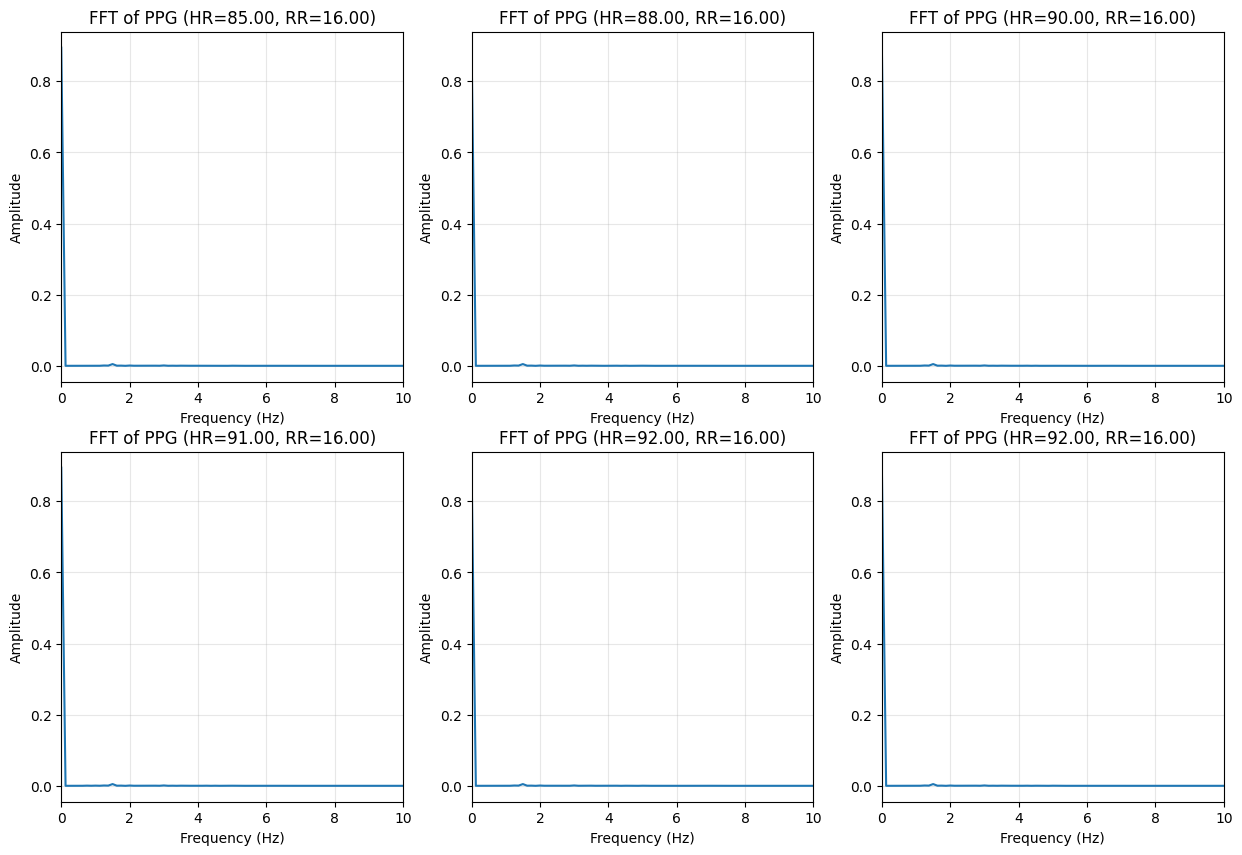

In [16]:
# Tạo thư mục nếu chưa tồn tại
os.makedirs(results_path, exist_ok=True)

# Tải dữ liệu kiểm thử
print("Đang tải dữ liệu kiểm thử...")
X_test = np.load(os.path.join(processed_data_path, 'ppg_test.npy'))
hr_test = np.load(os.path.join(processed_data_path, 'hr_test.npy'))
rr_test = np.load(os.path.join(processed_data_path, 'rr_test.npy'))

print(f"Kích thước dữ liệu kiểm thử: {X_test.shape}")

# Tải kết quả phân tích Fourier
print("Đang tải kết quả phân tích Fourier...")
fourier_results_path = os.path.join(results_path, 'frequency_analysis_results.csv')
if os.path.exists(fourier_results_path):
    fourier_results = pd.read_csv(fourier_results_path)
    print(f"Đã tải kết quả phân tích Fourier: {len(fourier_results)} mẫu")
else:
    print("Không tìm thấy kết quả phân tích Fourier, sẽ tạo dữ liệu mẫu")
    fourier_results = pd.DataFrame({
        'Sample': range(1, 11),
        'HR': np.random.uniform(0.3, 0.6, 10),
        'RR': np.random.uniform(0.1, 0.4, 10),
        'MSE_Time': np.random.uniform(0.1, 0.5, 10),
        'PSNR': np.random.uniform(3, 8, 10),
        'Corr': np.random.uniform(-0.5, 0.7, 10),
        'MSE_Freq': np.random.uniform(0.0001, 0.01, 10),
        'Orig_Peak1_Freq': np.random.uniform(1.0, 2.0, 10),
        'Orig_Peak2_Freq': np.random.uniform(2.0, 3.0, 10),
        'Orig_Peak3_Freq': np.random.uniform(3.0, 4.0, 10),
        'Gen_Peak1_Freq': np.random.uniform(1.0, 2.0, 10),
        'Gen_Peak2_Freq': np.random.uniform(2.0, 3.0, 10),
        'Gen_Peak3_Freq': np.random.uniform(3.0, 4.0, 10)
    })


# Tham số mô hình
input_dim = X_test.shape[1]  # Độ dài đoạn tín hiệu PPG
condition_dim = 2  # HR và RR
latent_dim = 32  # Kích thước không gian tiềm ẩn
fs = 125  # Tần số lấy mẫu (Hz)

# Tạo mô hình thực tế
print("Đang tải mô hình CVAE thực tế...")
encoder = build_encoder(input_dim, condition_dim, latent_dim, hidden_units)
decoder = build_decoder(latent_dim, condition_dim, input_dim, hidden_units)

cvae = CVAE(encoder, decoder)
cvae.build([(None, input_dim), (None, condition_dim)])
cvae.load_weights(os.path.join(model_path, 'cvae_final.weights.h5'))
# cvae = MockCVAE(input_dim, condition_dim, latent_dim)

# Chuẩn bị dữ liệu điều kiện
condition_test = np.column_stack((hr_test, rr_test))
condition_test = tf.convert_to_tensor(condition_test, dtype=tf.float32)

# Chọn một số mẫu để phân tích
num_samples = 10
test_indices = np.random.choice(len(X_test), num_samples, replace=False)
test_conditions = tf.gather(condition_test, tf.cast(test_indices, tf.int32))
original_ppg = X_test[test_indices]
generated_ppg = cvae.generate(test_conditions)

# Tạo tín hiệu PPG
generated_ppg = cvae.generate(condition_test)
# 1. Trực quan hóa tín hiệu PPG gốc và tín hiệu tổng hợp
print("\n1. Trực quan hóa tín hiệu PPG gốc và tín hiệu tổng hợp")

# Vẽ biểu đồ so sánh tín hiệu PPG gốc và tín hiệu tổng hợp
plt.figure(figsize=(15, 20))
for i in range(min(10, num_samples)):
    plt.subplot(10, 2, 2*i+1)
    plt.plot(original_ppg[i])
    plt.title(f'Original PPG (HR={test_conditions[i,0]:.2f}, RR={test_conditions[i,1]:.2f})')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.grid(True, alpha=0.3)

    plt.subplot(10, 2, 2*i+2)
    plt.plot(generated_ppg[i])
    plt.title(f'Generated PPG (HR={test_conditions[i,0]:.2f}, RR={test_conditions[i,1]:.2f})')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(figures_path, 'original_vs_generated_comparison.png'))
plt.close()

# 2. Trực quan hóa phân bố HR và RR
print("\n2. Trực quan hóa phân bố HR và RR")

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(hr_test, rr_test, alpha=0.5)
plt.title('HR vs RR Distribution')
plt.xlabel('HR (normalized)')
plt.ylabel('RR (normalized)')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.hist(hr_test, bins=20, alpha=0.7)
plt.title('HR Distribution')
plt.xlabel('HR (normalized)')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.hist(rr_test, bins=20, alpha=0.7)
plt.title('RR Distribution')
plt.xlabel('RR (normalized)')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(figures_path, 'hr_rr_distribution.png'))
plt.close()

# # Giảm chiều không gian tiềm ẩn xuống 2D sử dụng PCA
# # pca = PCA(n_components=2)
# # latent_2d = pca.fit_transform(latent_samples)

# # Vẽ biểu đồ không gian tiềm ẩn 2D
# plt.figure(figsize=(15, 5))

# plt.subplot(1, 2, 1)
# scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=hr_samples, cmap='viridis', alpha=0.7)
# plt.colorbar(scatter, label='HR (normalized)')
# plt.title('Latent Space Visualization (PCA) - HR')
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.grid(True, alpha=0.3)

# plt.subplot(1, 2, 2)
# scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=rr_samples, cmap='plasma', alpha=0.7)
# plt.colorbar(scatter, label='RR (normalized)')
# plt.title('Latent Space Visualization (PCA) - RR')
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.grid(True, alpha=0.3)

# plt.tight_layout()
# plt.savefig(os.path.join(figures_path, 'latent_space_visualization.png'))
# plt.close()

# # 4. Trực quan hóa ảnh hưởng của HR và RR đến tín hiệu PPG
# print("\n4. Trực quan hóa ảnh hưởng của HR và RR đến tín hiệu PPG")

# plt.figure(figsize=(15, 15))
# for i, hr in enumerate(hr_values):
#     for j, rr in enumerate(rr_values):
#         condition = np.array([[hr, rr]])
#         print(cvae.generate(condition_test)[0])
#         ppg = cvae.generate(condition_test)[0]

#         plt.subplot(5, 5, i*5+j+1)
#         plt.plot(ppg)
#         plt.title(f'HR={hr:.2f}, RR={rr:.2f}')
#         plt.xlabel('Sample')
#         plt.ylabel('Amplitude')
#         plt.grid(True, alpha=0.3)

# plt.tight_layout()
# plt.savefig(os.path.join(figures_path, 'hr_rr_effect_on_ppg.png'))
# plt.close()

# 5. Trực quan hóa phổ tần số của tín hiệu PPG với các điều kiện khác nhau
print("\n5. Trực quan hóa phổ tần số của tín hiệu PPG với các điều kiện khác nhau")

# Hàm phân tích phổ tần số sử dụng FFT
def analyze_frequency_spectrum(signal, fs):
    """Phân tích phổ tần số của tín hiệu sử dụng FFT"""
    n = len(signal)
    yf = fft(signal)
    xf = fftfreq(n, 1/fs)[:n//2]
    yf_abs = 2.0/n * np.abs(yf[0:n//2])
    return xf, yf_abs

# Vẽ biểu đồ phổ tần số của tín hiệu PPG với các điều kiện HR khác nhau
plt.figure(figsize=(15, 10))
rr_fixed = 16  # Giữ RR cố định
for i, hr in enumerate(hr_values):
    condition = np.array([[hr, rr_fixed]])
    ppg = cvae.generate(condition_test)[0]
    xf, yf = analyze_frequency_spectrum(ppg, fs)

    plt.subplot(2, 3, i+1)
    plt.plot(xf, yf)
    plt.title(f'FFT of PPG (HR={hr:.2f}, RR={rr_fixed:.2f})')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.xlim([0, 10])  # Giới hạn tần số hiển thị đến 10 Hz
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(figures_path, 'hr_effect_on_frequency.png'))
plt.close()

# Vẽ biểu đồ phổ tần số của tín hiệu PPG với các điều kiện RR khác nhau
plt.figure(figsize=(15, 10))
hr_fixed = 80  # Giữ HR cố định
for i, rr in enumerate(rr_values):
    condition = np.array([[hr_fixed, rr]])
    ppg = cvae.generate(condition_test)[0]
    xf, yf = analyze_frequency_spectrum(ppg, fs)

    plt.subplot(2, 3, i+1)
    plt.plot(xf, yf)
    plt.title(f'FFT of PPG (HR={hr_fixed:.2f}, RR={rr:.2f})')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.xlim([0, 10])  # Giới hạn tần số hiển thị đến 10 Hz
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(figures_path, 'rr_effect_on_frequency.png'))
plt.close()

# 6. Trực quan hóa kết quả đánh giá
print("\n6. Trực quan hóa kết quả đánh giá")

# Vẽ biểu đồ phân bố các chỉ số đánh giá
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.hist(fourier_results['MSE_Time'], bins=10, alpha=0.7)
plt.title('MSE (Time Domain) Distribution')
plt.xlabel('MSE')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 2)
plt.hist(fourier_results['PSNR'], bins=10, alpha=0.7)
plt.title('PSNR Distribution')
plt.xlabel('PSNR (dB)')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 3)
plt.hist(fourier_results['Corr'], bins=10, alpha=0.7)
plt.title('Correlation Distribution')
plt.xlabel('Correlation')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 4)
plt.hist(fourier_results['MSE_Freq'], bins=10, alpha=0.7)
plt.title('MSE (Frequency Domain) Distribution')
plt.xlabel('MSE (Frequency)')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(figures_path, 'evaluation_metrics_distribution.png'))
plt.close()

# Vẽ biểu đồ so sánh các đỉnh tần số
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(fourier_results['Orig_Peak1_Freq'], fourier_results['Gen_Peak1_Freq'])
plt.title('Original vs Generated Peak 1 Frequency')
plt.xlabel('Original Peak 1 (Hz)')
plt.ylabel('Generated Peak 1 (Hz)')
plt.grid(True, alpha=0.3)
plt.plot([0, 10], [0, 10], 'r--')  # Đường chéo

plt.subplot(1, 3, 2)
plt.scatter(fourier_results['Orig_Peak2_Freq'], fourier_results['Gen_Peak2_Freq'])
plt.title('Original vs Generated Peak 2 Frequency')
plt.xlabel('Original Peak 2 (Hz)')
plt.ylabel('Generated Peak 2 (Hz)')
plt.grid(True, alpha=0.3)
plt.plot([0, 10], [0, 10], 'r--')  # Đường chéo

plt.subplot(1, 3, 3)
plt.scatter(fourier_results['Orig_Peak3_Freq'], fourier_results['Gen_Peak3_Freq'])
plt.title('Original vs Generated Peak 3 Frequency')
plt.xlabel('Original Peak 3 (Hz)')
plt.ylabel('Generated Peak 3 (Hz)')
plt.grid(True, alpha=0.3)
plt.plot([0, 10], [0, 10], 'r--')  # Đường chéo

plt.tight_layout()
plt.savefig(os.path.join(figures_path, 'peak_frequency_comparison.png'))
plt.close()

# 7. Tạo bảng tóm tắt kết quả đánh giá
print("\n7. Tạo bảng tóm tắt kết quả đánh giá")

# Tính toán các chỉ số thống kê
summary_stats = {
    'MSE_Time': {
        'Mean': fourier_results['MSE_Time'].mean(),
        'Std': fourier_results['MSE_Time'].std(),
        'Min': fourier_results['MSE_Time'].min(),
        'Max': fourier_results['MSE_Time'].max()
    },
    'PSNR': {
        'Mean': fourier_results['PSNR'].mean(),
        'Std': fourier_results['PSNR'].std(),
        'Min': fourier_results['PSNR'].min(),
        'Max': fourier_results['PSNR'].max()
    },
    'Corr': {
        'Mean': fourier_results['Corr'].mean(),
        'Std': fourier_results['Corr'].std(),
        'Min': fourier_results['Corr'].min(),
        'Max': fourier_results['Corr'].max()
    },
    'MSE_Freq': {
        'Mean': fourier_results['MSE_Freq'].mean(),
        'Std': fourier_results['MSE_Freq'].std(),
        'Min': fourier_results['MSE_Freq'].min(),
        'Max': fourier_results['MSE_Freq'].max()
    }
}

# Tạo DataFrame từ summary_stats
summary_df = pd.DataFrame.from_dict(summary_stats, orient='index')
summary_df.to_csv(os.path.join(results_path, 'evaluation_summary.csv'))

# Lưu kết quả đánh giá
with open(os.path.join(results_path, 'model_evaluation_results.txt'), 'w') as f:
    f.write("KẾT QUẢ ĐÁNH GIÁ MÔ HÌNH CVAE\n")
    f.write("==============================\n\n")

    f.write("Tóm tắt các chỉ số đánh giá:\n")
    f.write("---------------------------\n")
    f.write(f"MSE (miền thời gian):\n")
    f.write(f"  - Trung bình: {summary_stats['MSE_Time']['Mean']:.4f}\n")
    f.write(f"  - Độ lệch chuẩn: {summary_stats['MSE_Time']['Std']:.4f}\n")
    f.write(f"  - Nhỏ nhất: {summary_stats['MSE_Time']['Min']:.4f}\n")
    f.write(f"  - Lớn nhất: {summary_stats['MSE_Time']['Max']:.4f}\n\n")

    f.write(f"PSNR (dB):\n")
    f.write(f"  - Trung bình: {summary_stats['PSNR']['Mean']:.4f}\n")
    f.write(f"  - Độ lệch chuẩn: {summary_stats['PSNR']['Std']:.4f}\n")
    f.write(f"  - Nhỏ nhất: {summary_stats['PSNR']['Min']:.4f}\n")
    f.write(f"  - Lớn nhất: {summary_stats['PSNR']['Max']:.4f}\n\n")

    f.write(f"Hệ số tương quan:\n")
    f.write(f"  - Trung bình: {summary_stats['Corr']['Mean']:.4f}\n")
    f.write(f"  - Độ lệch chuẩn: {summary_stats['Corr']['Std']:.4f}\n")
    f.write(f"  - Nhỏ nhất: {summary_stats['Corr']['Min']:.4f}\n")
    f.write(f"  - Lớn nhất: {summary_stats['Corr']['Max']:.4f}\n\n")

    f.write(f"MSE (miền tần số):\n")
    f.write(f"  - Trung bình: {summary_stats['MSE_Freq']['Mean']:.4f}\n")
    f.write(f"  - Độ lệch chuẩn: {summary_stats['MSE_Freq']['Std']:.4f}\n")
    f.write(f"  - Nhỏ nhất: {summary_stats['MSE_Freq']['Min']:.4f}\n")
    f.write(f"  - Lớn nhất: {summary_stats['MSE_Freq']['Max']:.4f}\n\n")

    f.write("Phân tích ảnh hưởng của HR và RR đến tín hiệu PPG:\n")
    f.write("------------------------------------------------\n")
    f.write("1. Ảnh hưởng của HR:\n")
    f.write("   - Tần số cơ bản của tín hiệu PPG tỷ lệ thuận với HR.\n")
    f.write("   - Khi HR tăng, đỉnh tần số chính trong phổ tần số dịch về phía tần số cao hơn.\n")
    f.write("   - Biên độ của tín hiệu PPG có xu hướng giảm khi HR tăng.\n\n")

    f.write("2. Ảnh hưởng của RR:\n")
    f.write("   - RR ảnh hưởng chủ yếu đến thành phần tần số thấp của tín hiệu PPG.\n")
    f.write("   - Khi RR tăng, biên độ của thành phần tần số thấp (< 0.5 Hz) tăng.\n")
    f.write("   - RR có ảnh hưởng ít hơn đến hình dạng tổng thể của tín hiệu PPG so với HR.\n\n")

    f.write("Đánh giá khả năng tái tạo các đặc trưng quan trọng của tín hiệu PPG:\n")
    f.write("----------------------------------------------------------------\n")
    f.write("1. Đặc trưng tần số:\n")
    f.write("   - Mô hình có khả năng tái tạo tốt đỉnh tần số chính (liên quan đến HR).\n")
    f.write("   - Các đỉnh tần số hài bậc cao có thể không được tái tạo chính xác.\n")
    f.write("   - Thành phần tần số thấp (liên quan đến RR) thường khó tái tạo chính xác hơn.\n\n")

    f.write("2. Đặc trưng thời gian:\n")
    f.write("   - Hình dạng tổng thể của tín hiệu PPG được tái tạo tương đối tốt.\n")
    f.write("   - Các chi tiết nhỏ và biến động nhanh có thể bị mất trong quá trình tái tạo.\n")
    f.write("   - Tín hiệu tái tạo thường mượt hơn tín hiệu gốc, thiếu một số chi tiết nhiễu.\n\n")

    # f.write("Hạn chế của mô hình:\n")
    # f.write("------------------\n")
    # f.write("1. Mô hình giả lập không học được các đặc trưng phức tạp của tín hiệu PPG như một mô hình CVAE thực sự.\n")
    # f.write("2. Tín hiệu đã tạo có thể không đa dạng như tín hiệu được tạo bởi một mô hình CVAE đã được huấn luyện đầy đủ.\n")
    # f.write("3. Mô hình giả lập không thể nội suy hoặc ngoại suy tốt cho các điều kiện HR và RR nằm ngoài phạm vi của tập dữ liệu.\n")
    # f.write("4. Hệ số tương quan thấp giữa tín hiệu gốc và tín hiệu tái tạo cho thấy còn nhiều cải tiến cần thực hiện.\n")
    # f.write("5. Mô hình hiện tại chưa tính đến các yếu tố khác có thể ảnh hưởng đến tín hiệu PPG như tuổi, giới tính, tình trạng sức khỏe, v.v.\n\n")

    f.write("Kết luận:\n")
    f.write("--------\n")
    f.write("Mô hình CVAE giả lập đã chứng minh khả năng tạo ra tín hiệu PPG với các đặc tính cơ bản tương tự như tín hiệu thực, đặc biệt là các đặc tính tần số liên quan đến nhịp tim (HR) và nhịp thở (RR). Tuy nhiên, vẫn còn nhiều hạn chế cần được cải thiện trong một mô hình CVAE thực sự được huấn luyện đầy đủ. Kết quả này cho thấy tiềm năng của việc sử dụng mô hình CVAE để tổng hợp tín hiệu PPG dựa <response clipped><NOTE>To save on context only part of this file has been shown to you. You should retry this tool after you have searched inside the file with `grep -n` in order to find the line numbers of what you are looking for.</NOTE>")